In [15]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETH-Hell-AP\\2806stats.json") as f:
    data = json.load(f)


TypeError: cannot unpack non-iterable int object

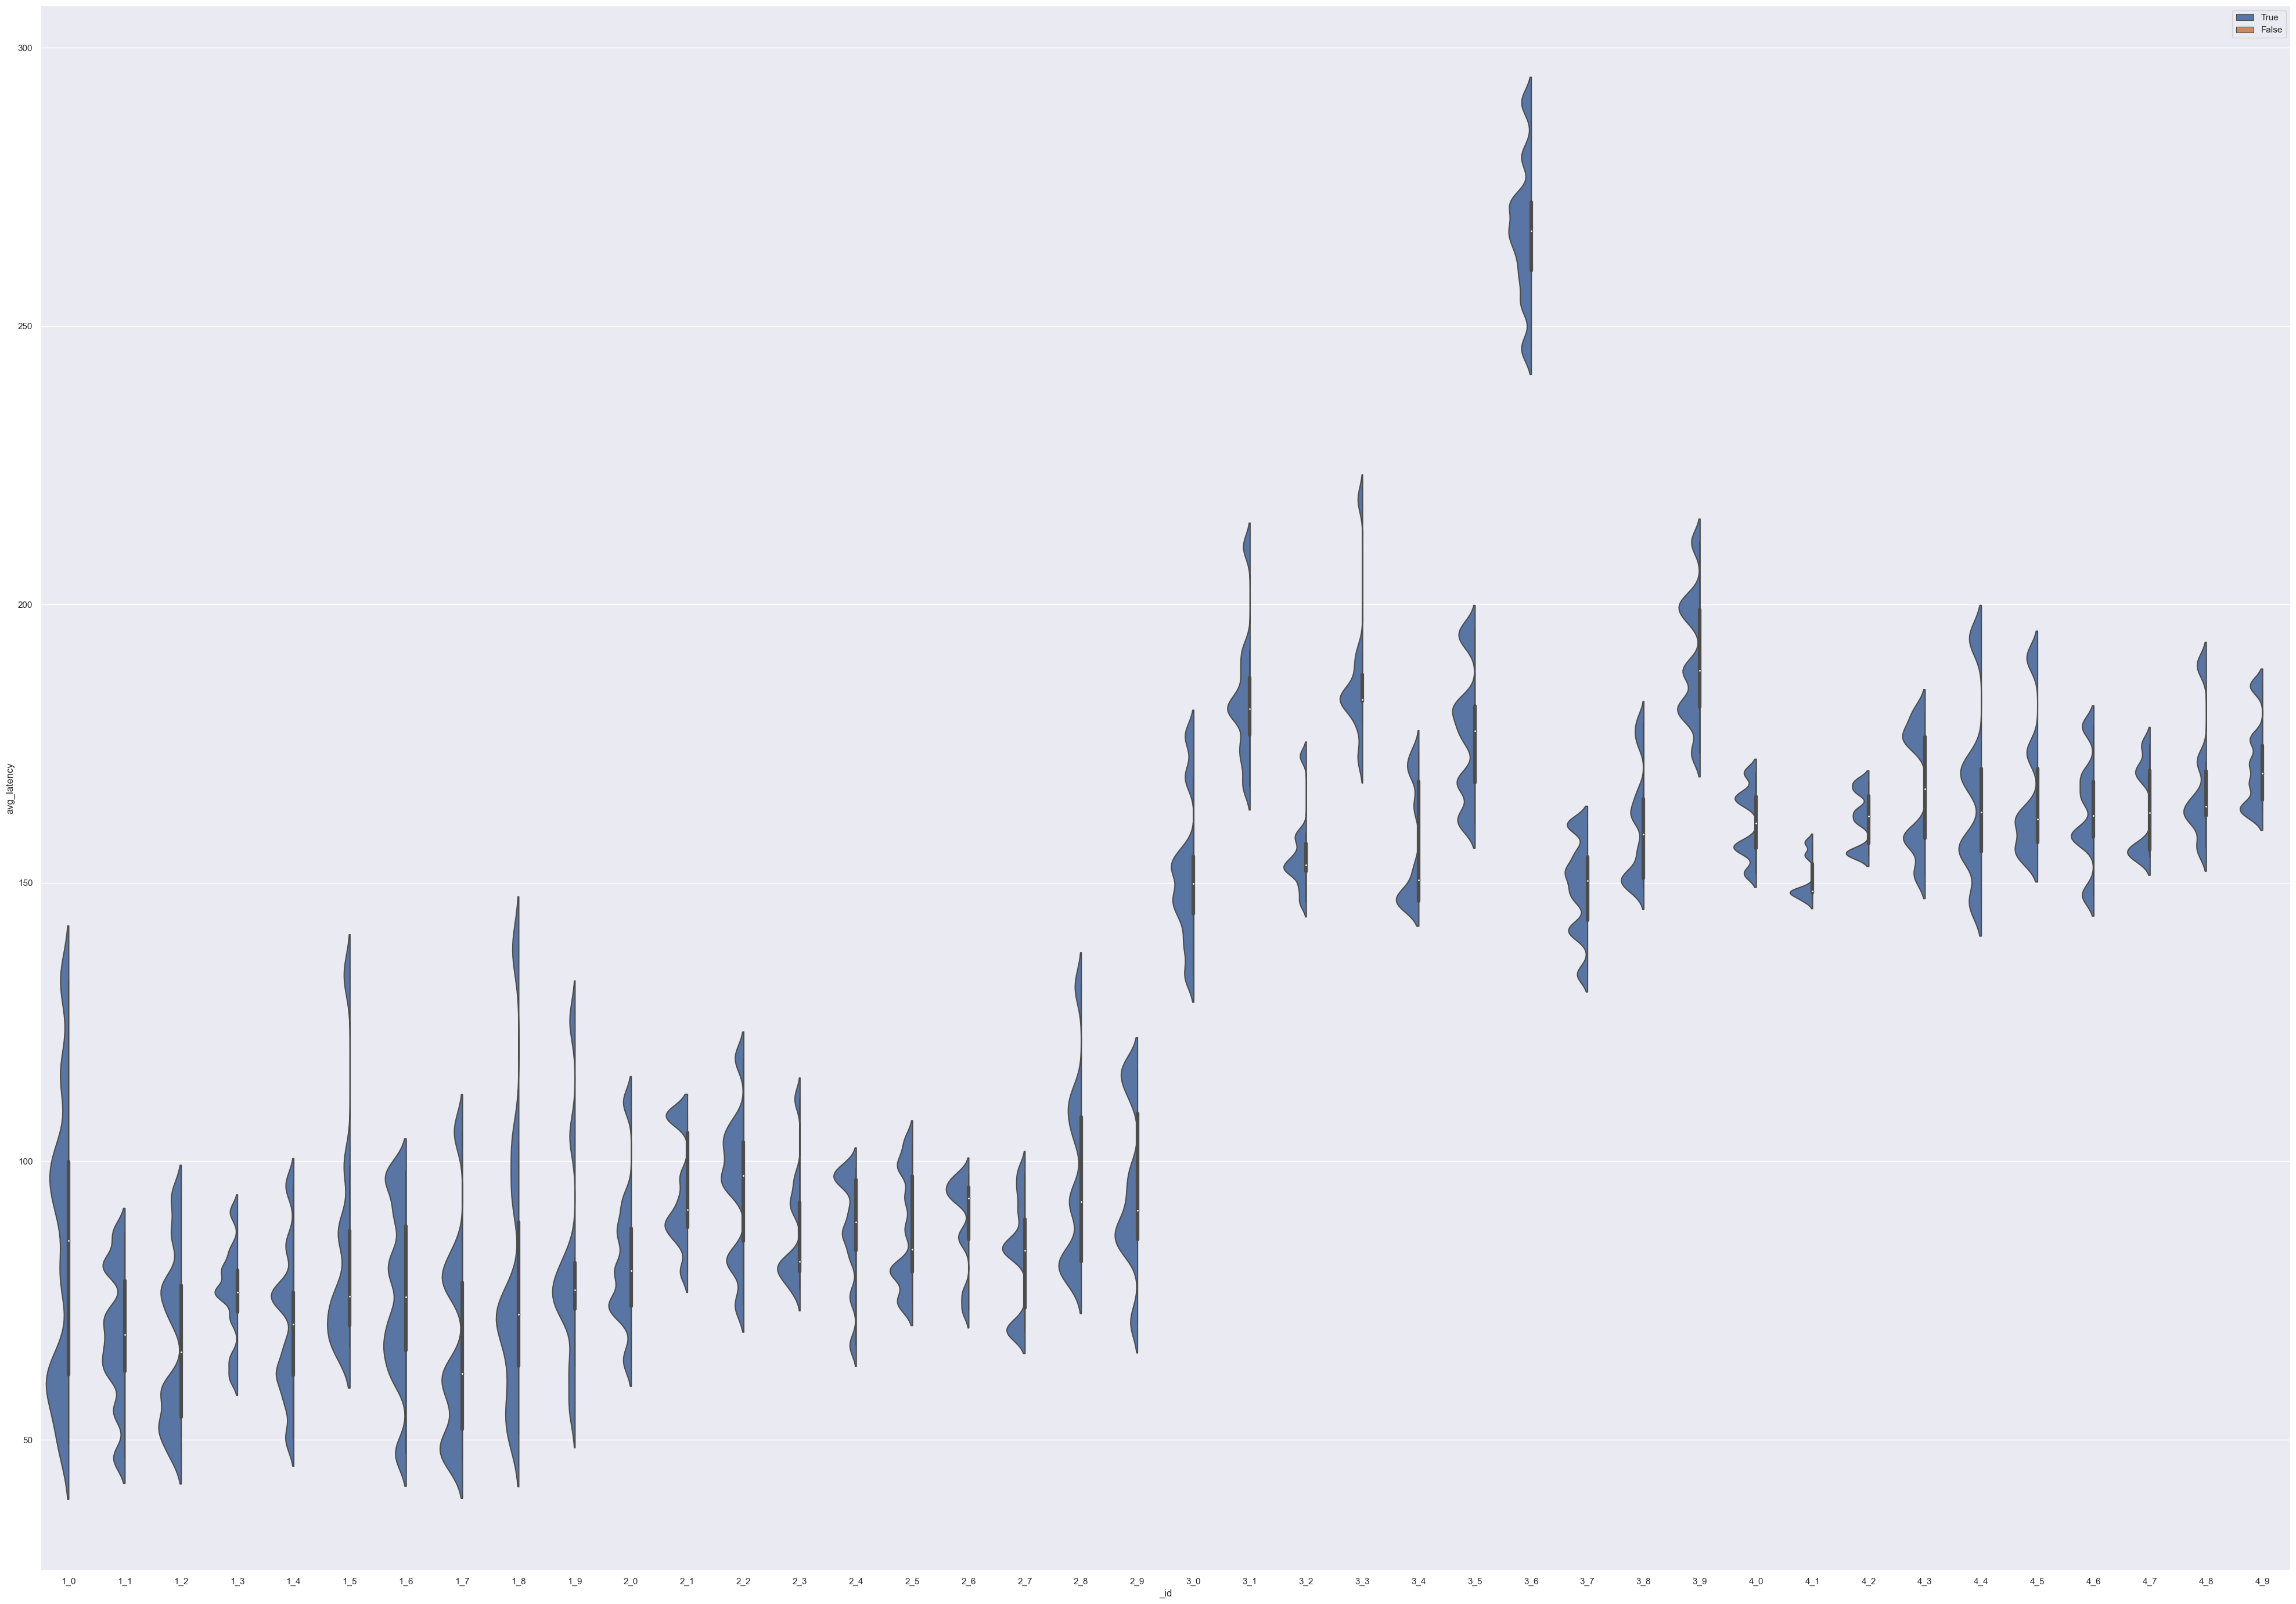

In [24]:
# Convert pymongo cursor to a list of dictionaries
# Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# Create the violin plot
ax = sns.violinplot(
    data=df, x="_id", y="avg_latency",
    hue=True,
    hue_order=[True, False], split=True,
    bw=0.18,
    scale="count",
)

# Add the frequency indicator
counts = df['_id'].value_counts()
for i, count in enumerate(counts):
    ax.annotate(count, xy=(i, 310), ha='center', va='center')
custom_ticks = []
for i in range(40, 300, 5):
    custom_ticks.append(i)

sns.set(rc={"figure.figsize":(50, 35)})
plt.yticks(custom_ticks, [str(tick) for tick in custom_ticks])  # Set the custom ticks
plt.ylabel("Average Latency (ms)")
plt.xlabel("PathID")
plt.ylim([40.0, 300.0])
plt.show()


In [10]:

df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''))
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''))


In [11]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETH-Hell-AP\\2806stats.json") as f:
    data = json.load(f)

# Convert pymongo cursor to a list of dictionaries
# data = list(documents)

# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# ordered_ids = df['_id'].value_counts().index
# g = sns.FacetGrid(df, row="_id", row_order=ordered_ids, height=5, aspect=2)

# g.map(sns.histplot, "avg_latency")

# custom_ticks = []
# for i in range(40, 105, 3):
#     custom_ticks.append(i)

# sns.set(rc={"figure.figsize":(15, 15)})
# plt.yticks(custom_ticks, [str(tick) for tick in custom_ticks])  # Set the custom ticks
# plt.ylabel("Average Latency (ms)")
# plt.xlabel("PathID")
# plt.ylim([40.0,104.0])
# plt.show()
print(df)

     _id  avg_latency avg_bandwidth_cs_64 avg_bandwidth_sc_64  \
0    1_0    49.209900            1.54Mbps            3.38Mbps   
1    1_1    61.637259            1.64Mbps            4.56Mbps   
2    1_2    76.393577            1.63Mbps            4.01Mbps   
3    1_3    76.607538            1.65Mbps            4.01Mbps   
4    1_4    62.360375            1.60Mbps            3.53Mbps   
..   ...          ...                 ...                 ...   
355  4_5   162.008654            1.57Mbps            5.62Mbps   
356  4_6   165.357462            1.58Mbps            5.37Mbps   
357  4_7   156.163000            1.59Mbps            5.42Mbps   
358  4_8   171.815640            1.58Mbps            5.13Mbps   
359  4_9   162.559640            1.57Mbps            5.15Mbps   

    avg_bandwidth_cs_MTU avg_bandwidth_sc_MTU avg_loss  \
0               0.06Mbps             0.32Mbps       0%   
1               0.04Mbps             0.27Mbps      10%   
2               0.05Mbps             0.31Mbps

In [12]:
import matplotlib.pyplot as plt

C:\Users\maxbr\AppData\Local\Temp\ipykernel_18976\366625117.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax, bx) = plt.subplots(1,2, figsize=(50,5))


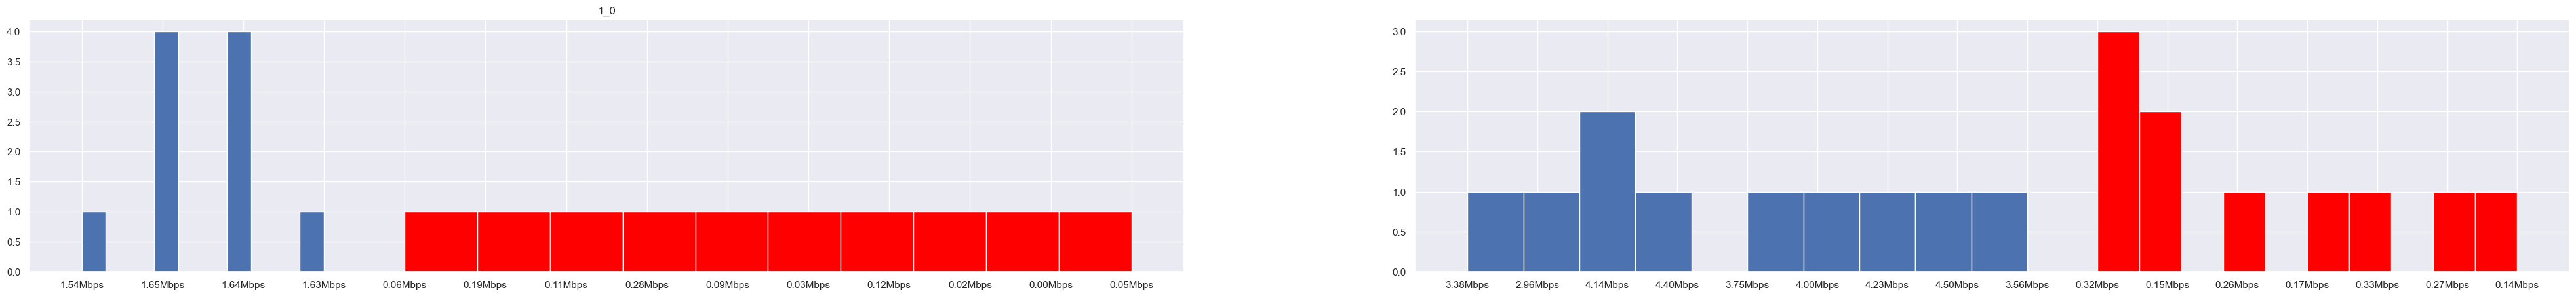

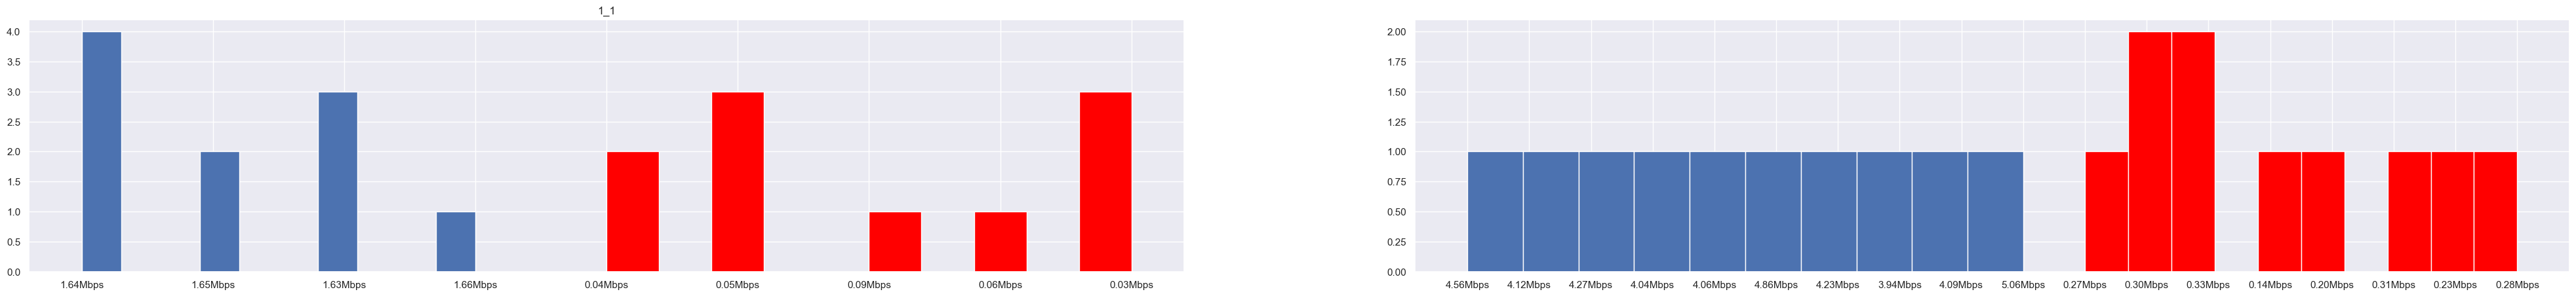

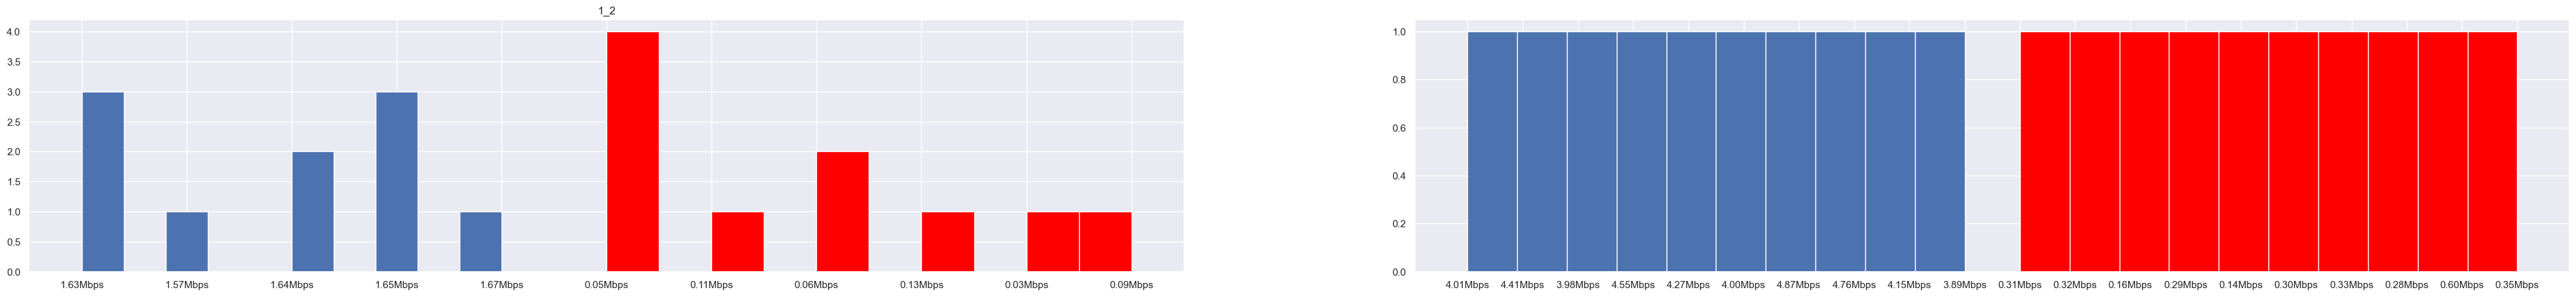

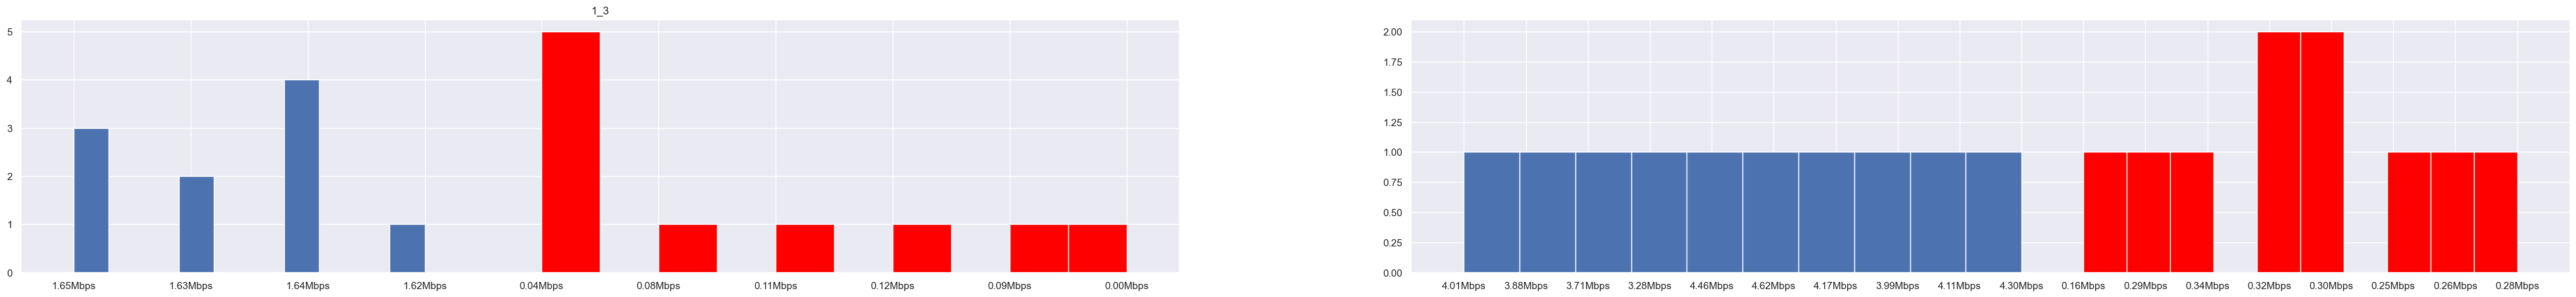

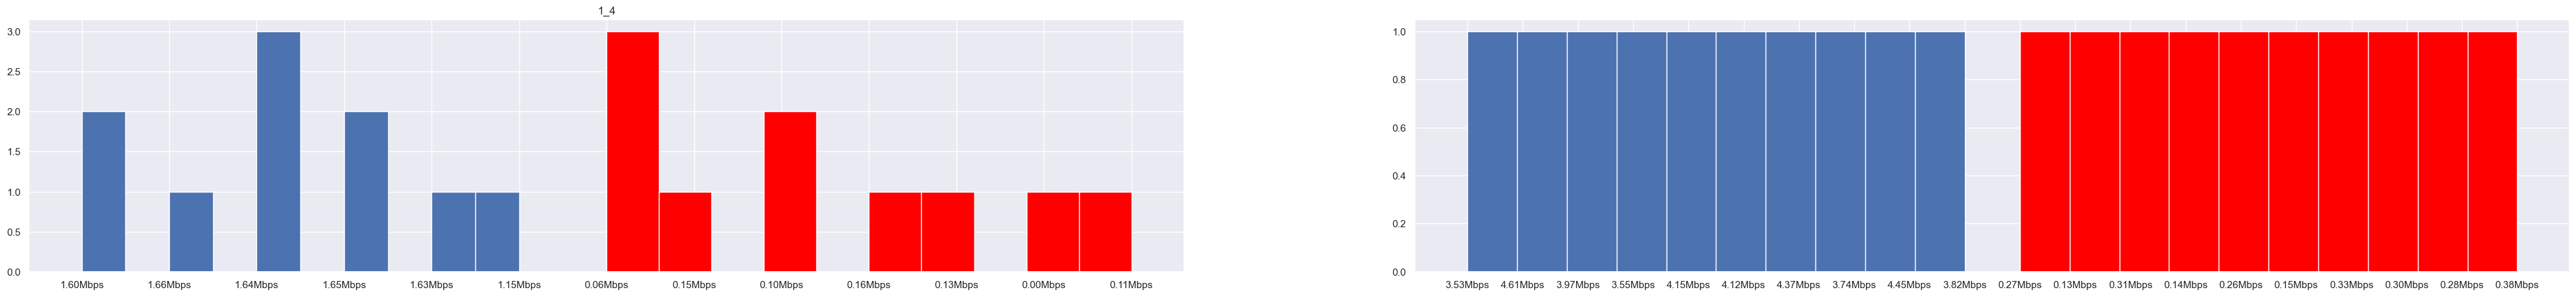

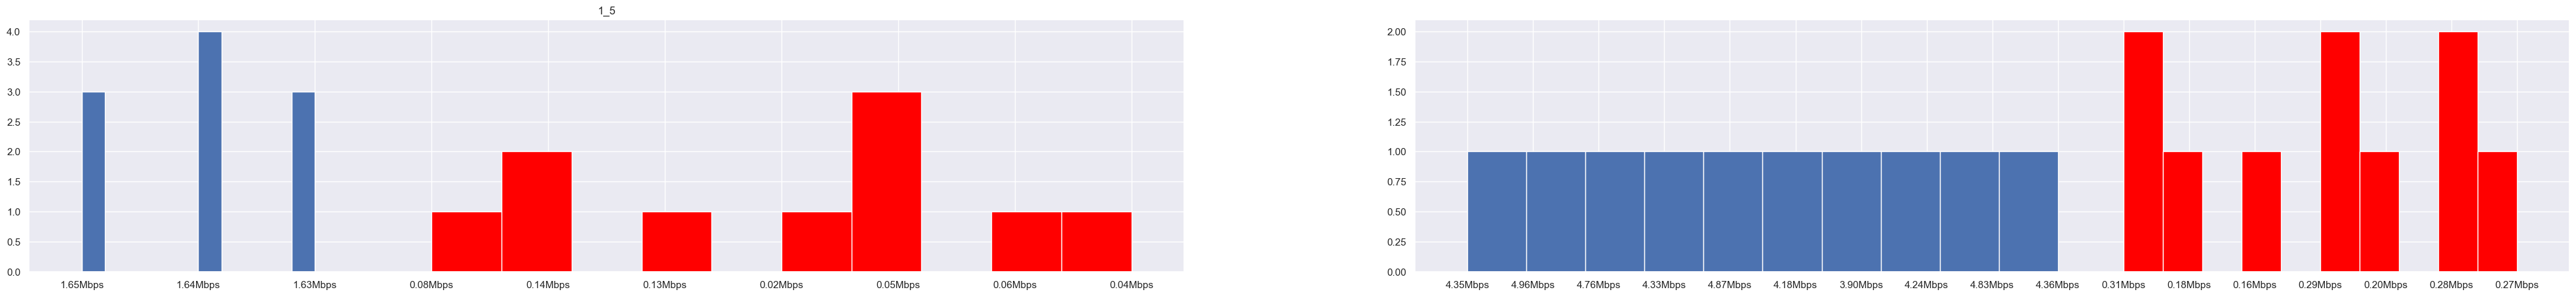

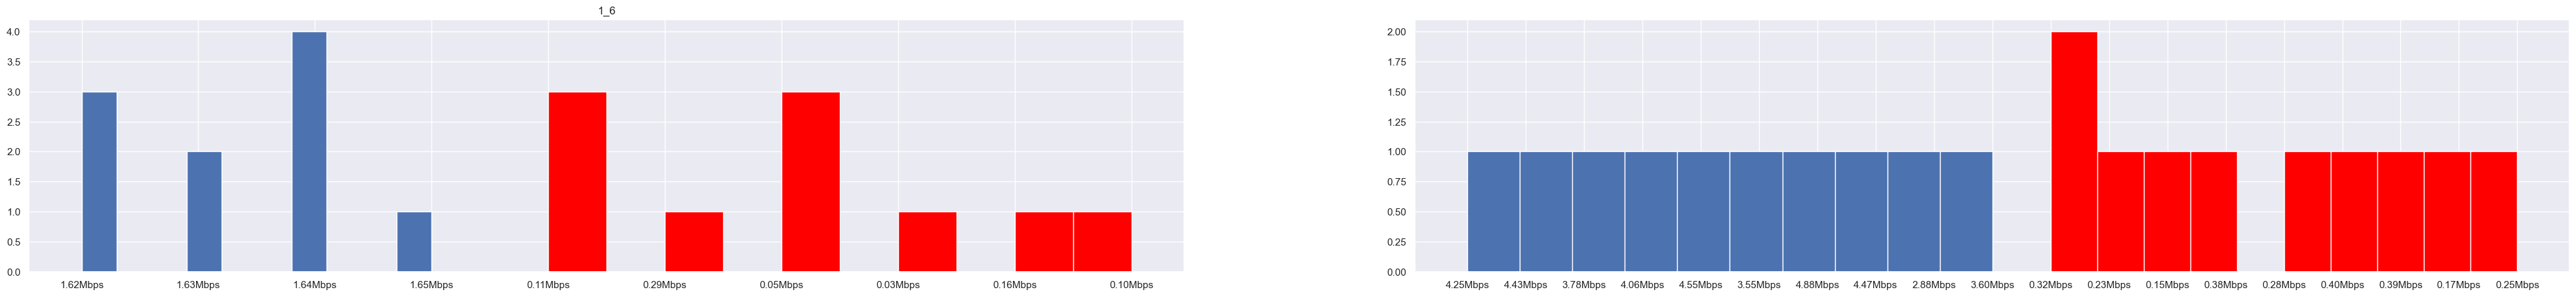

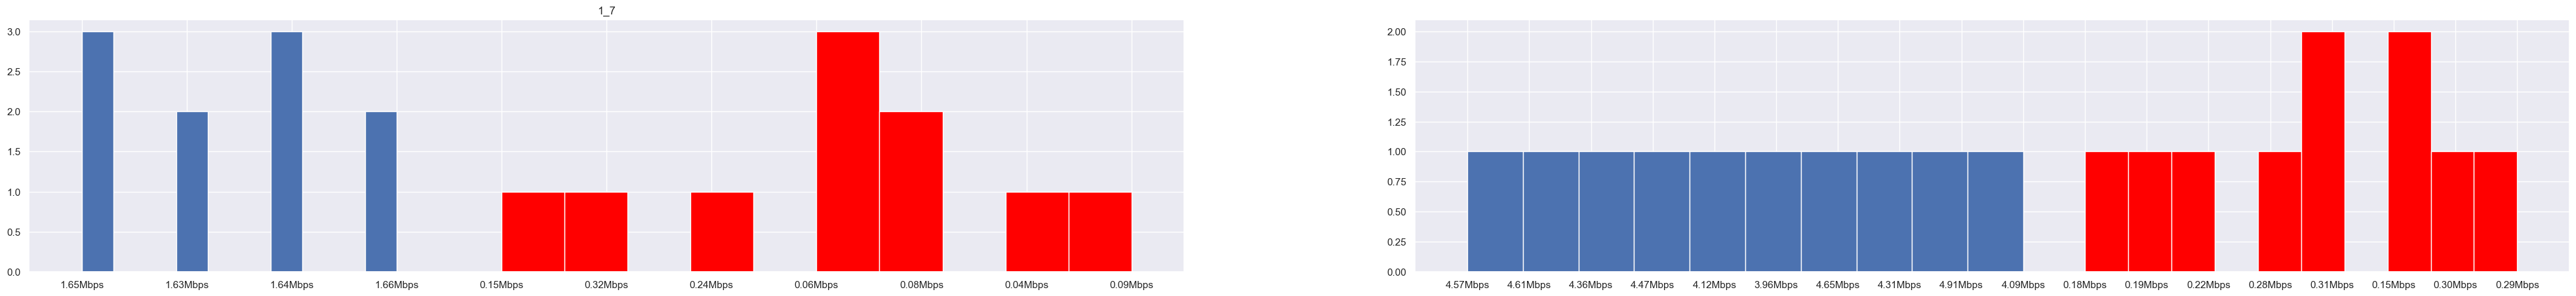

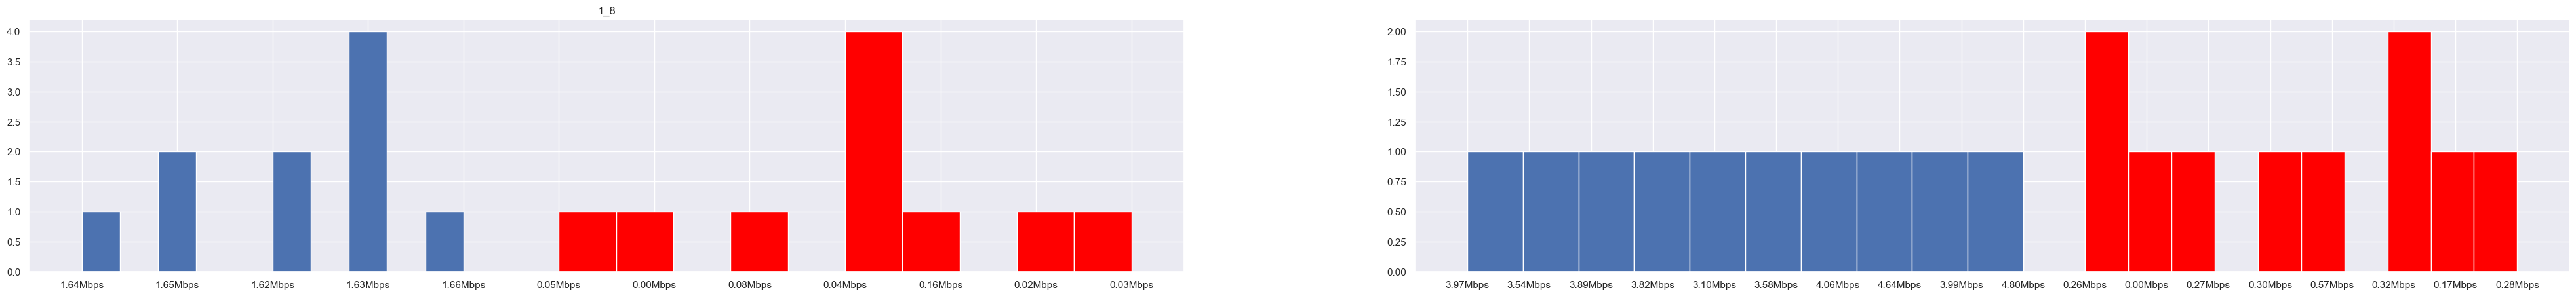

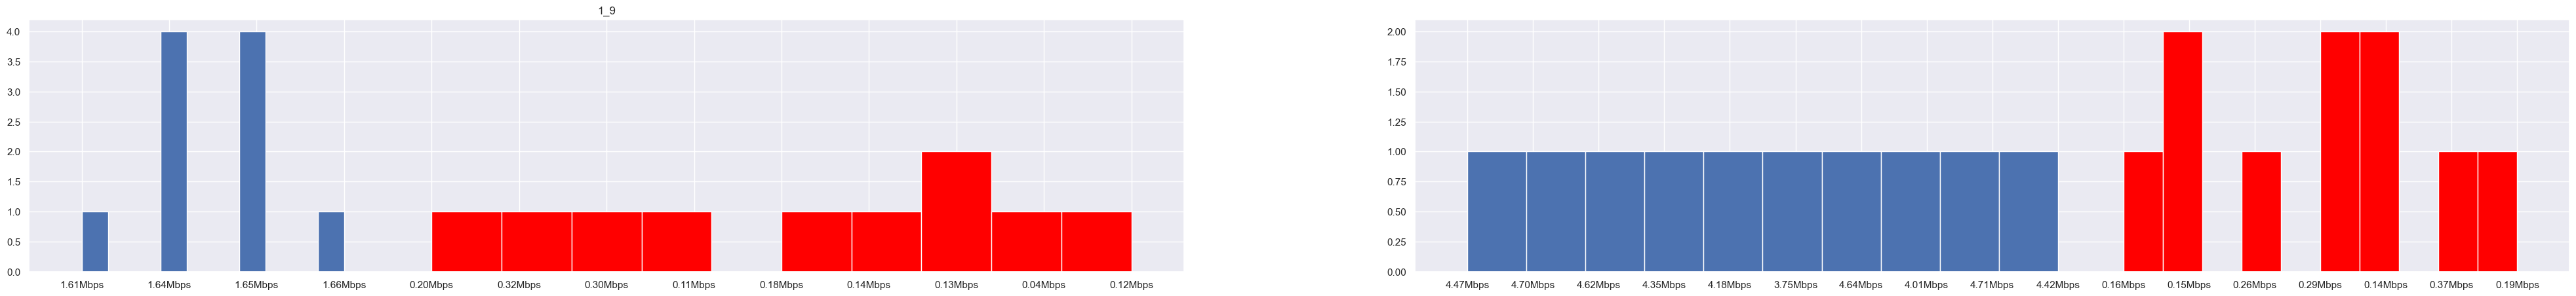

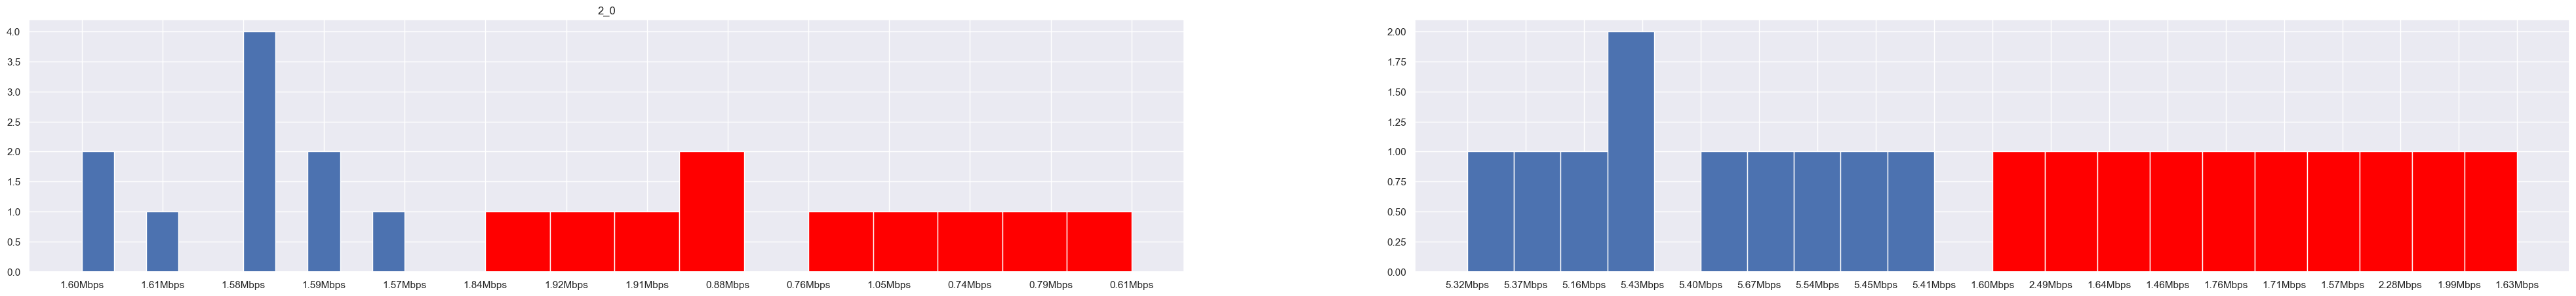

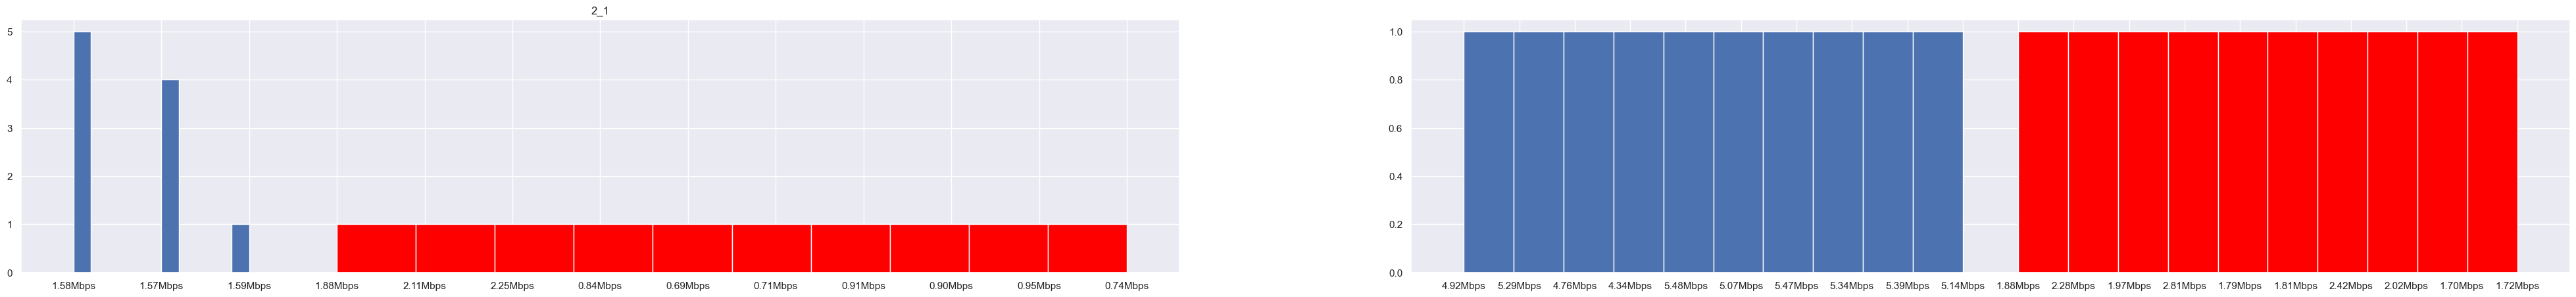

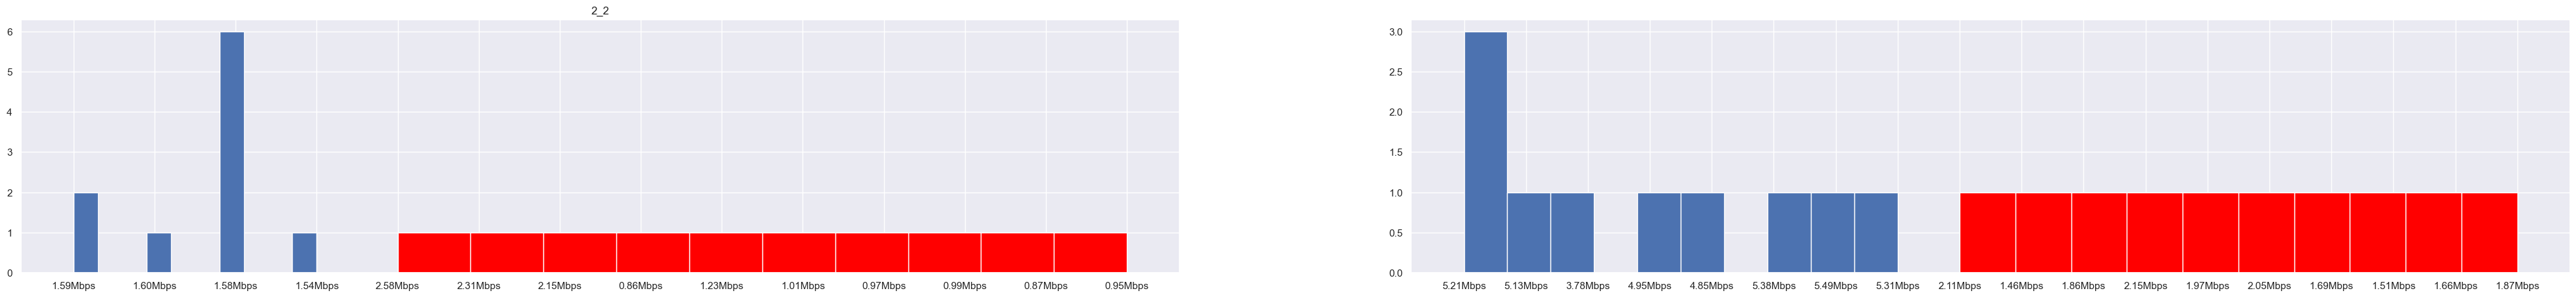

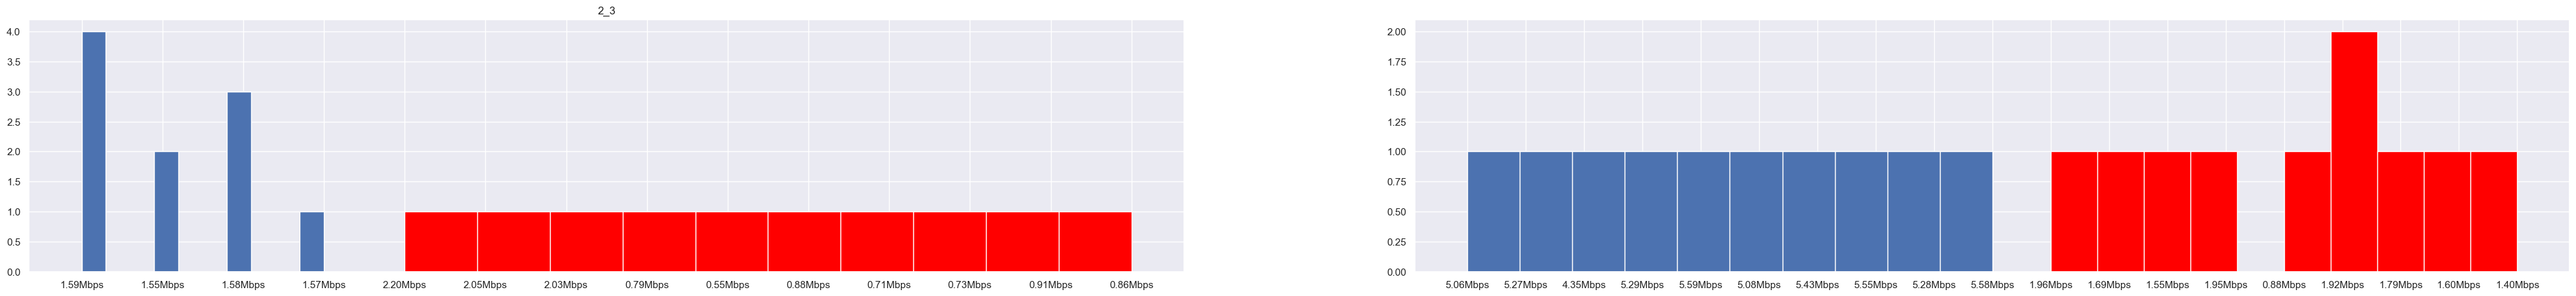

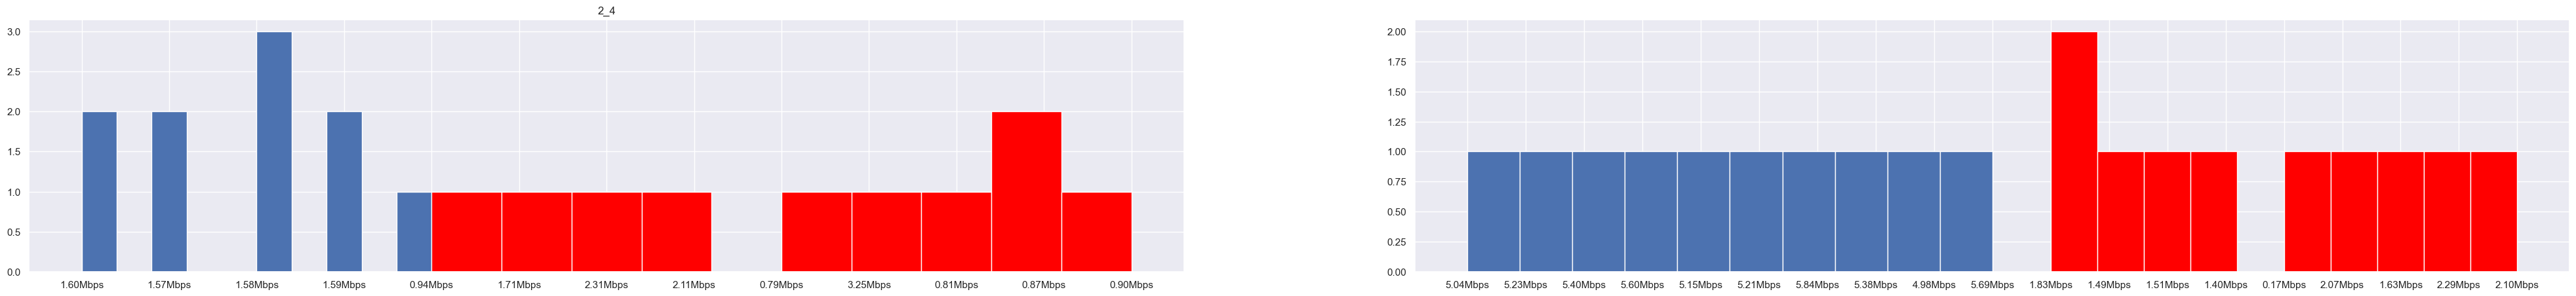

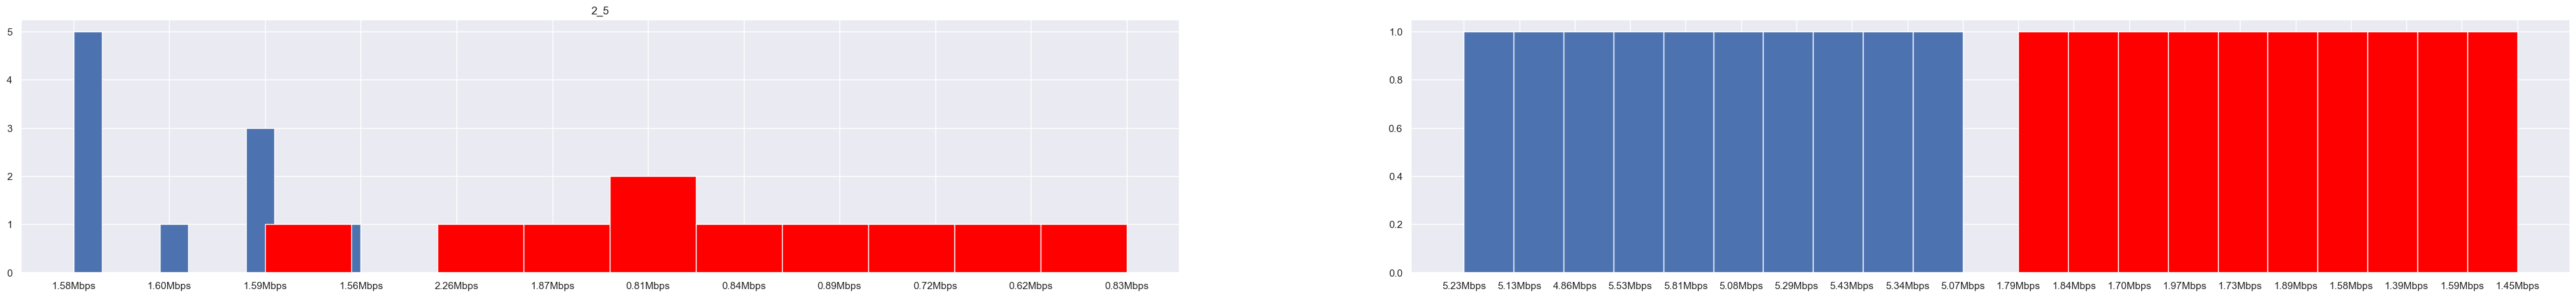

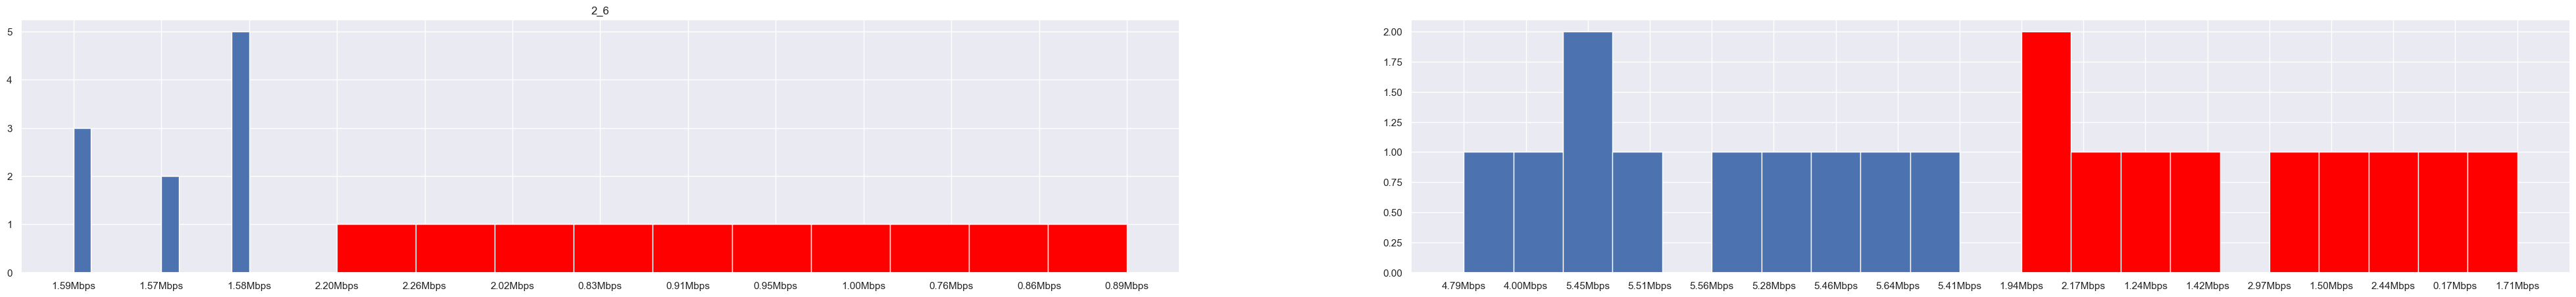

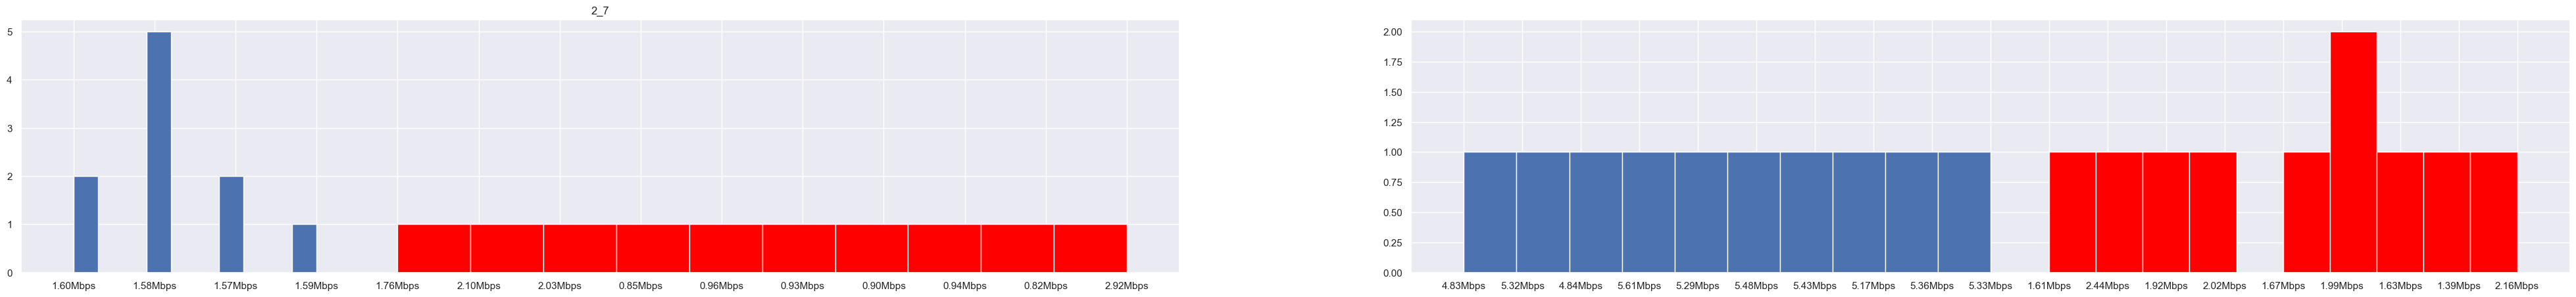

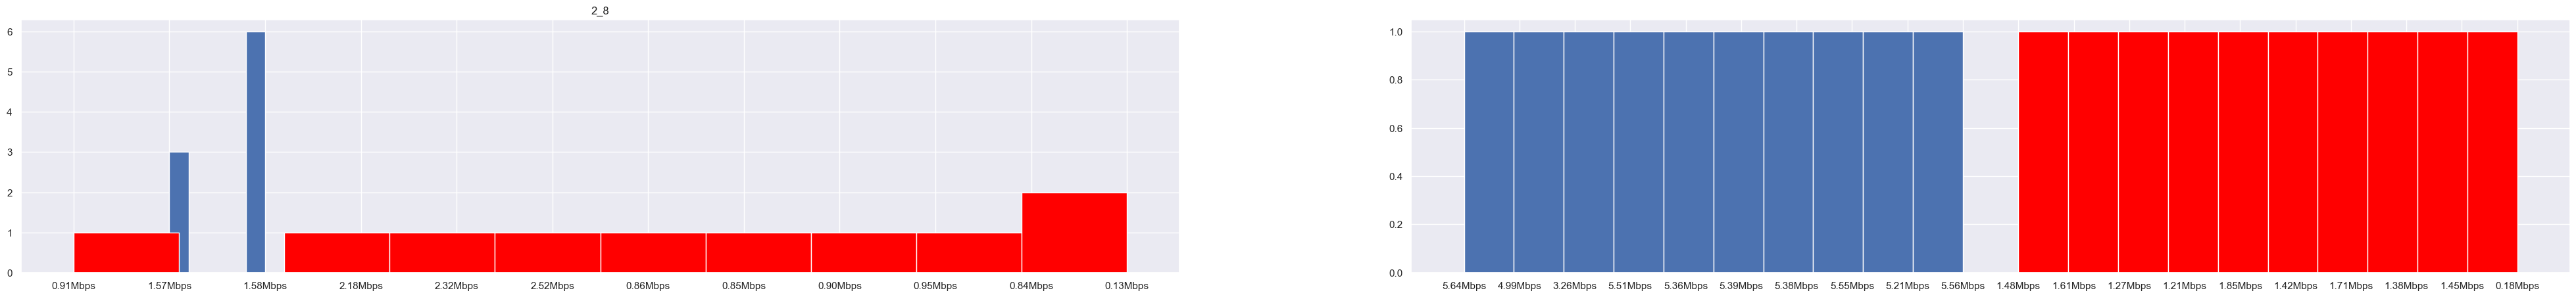

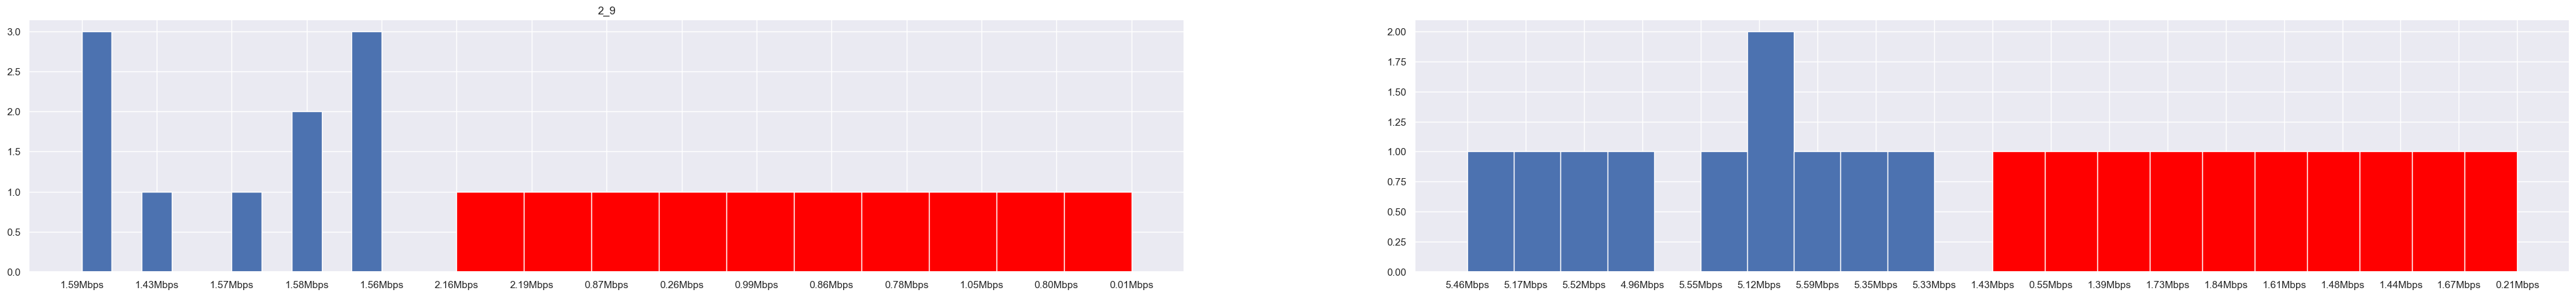

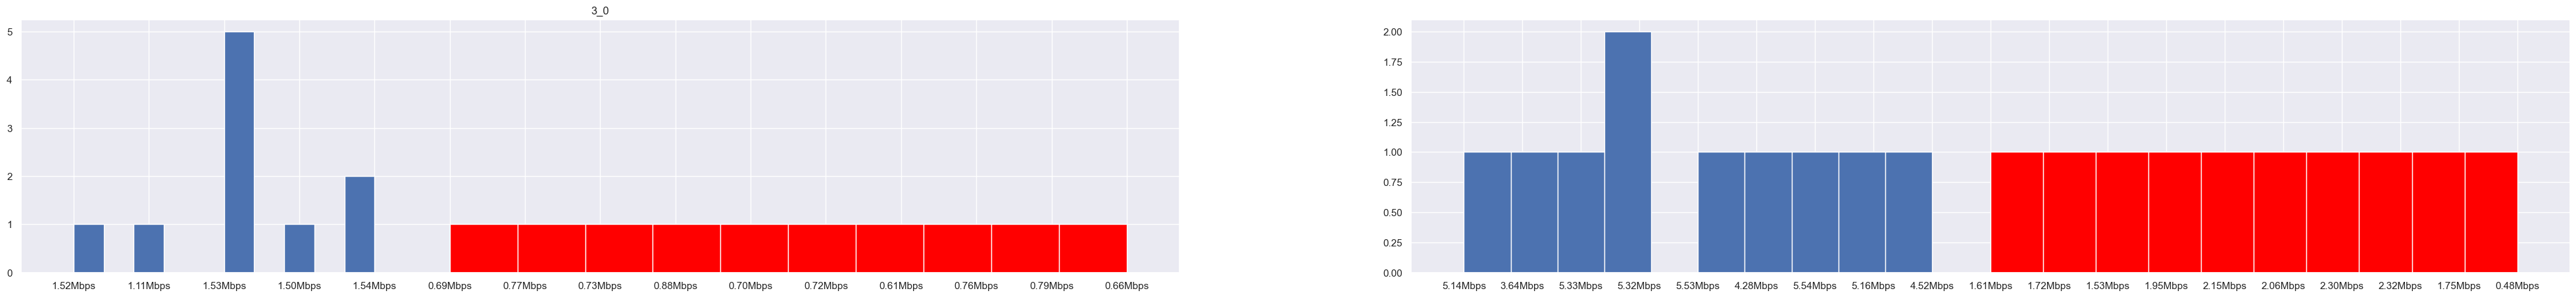

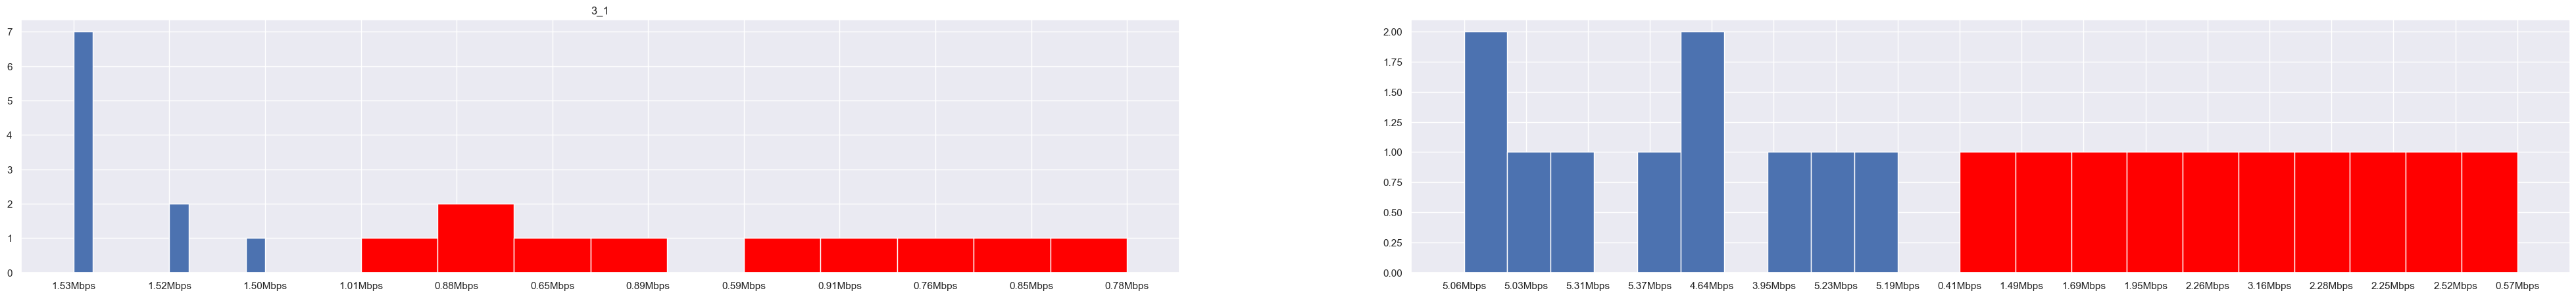

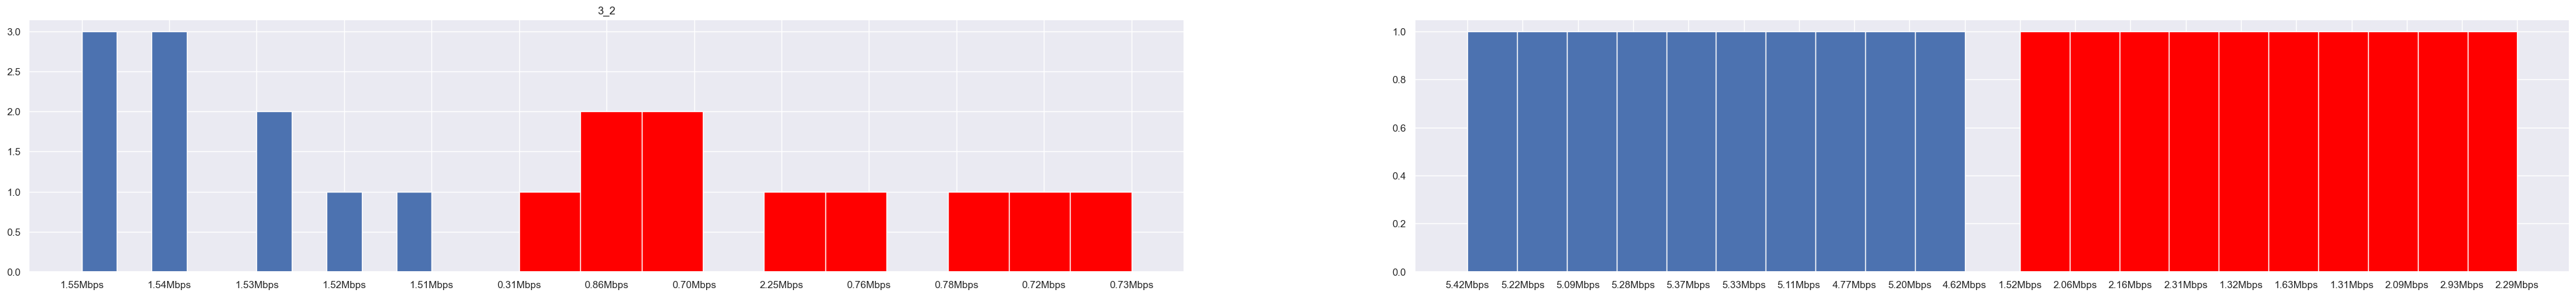

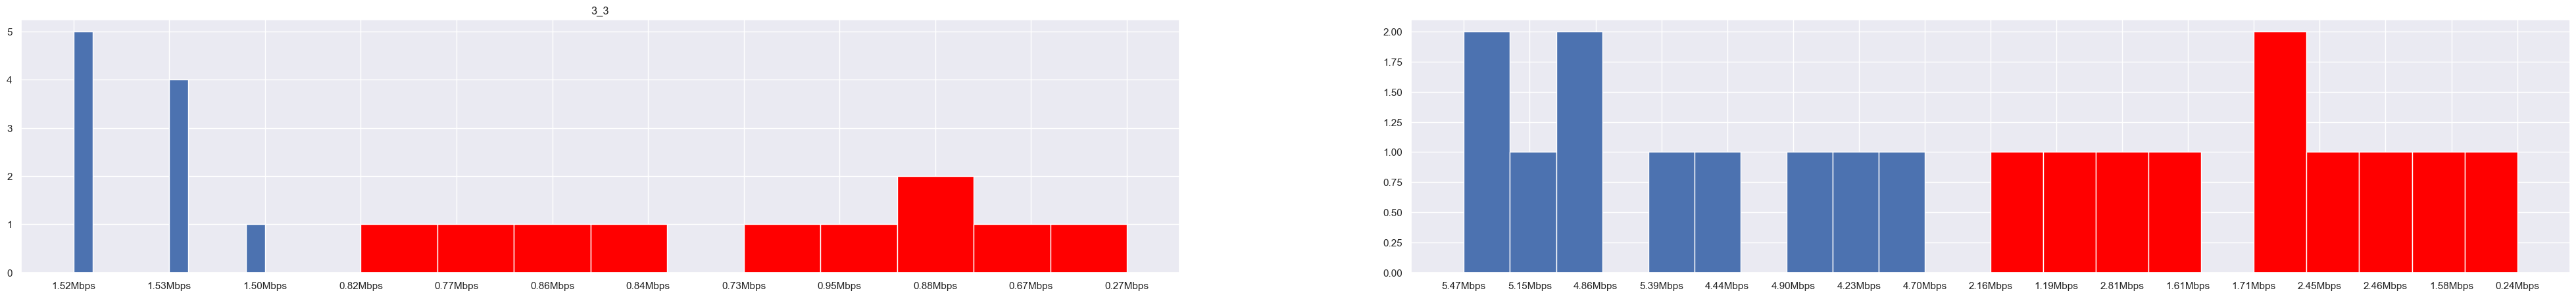

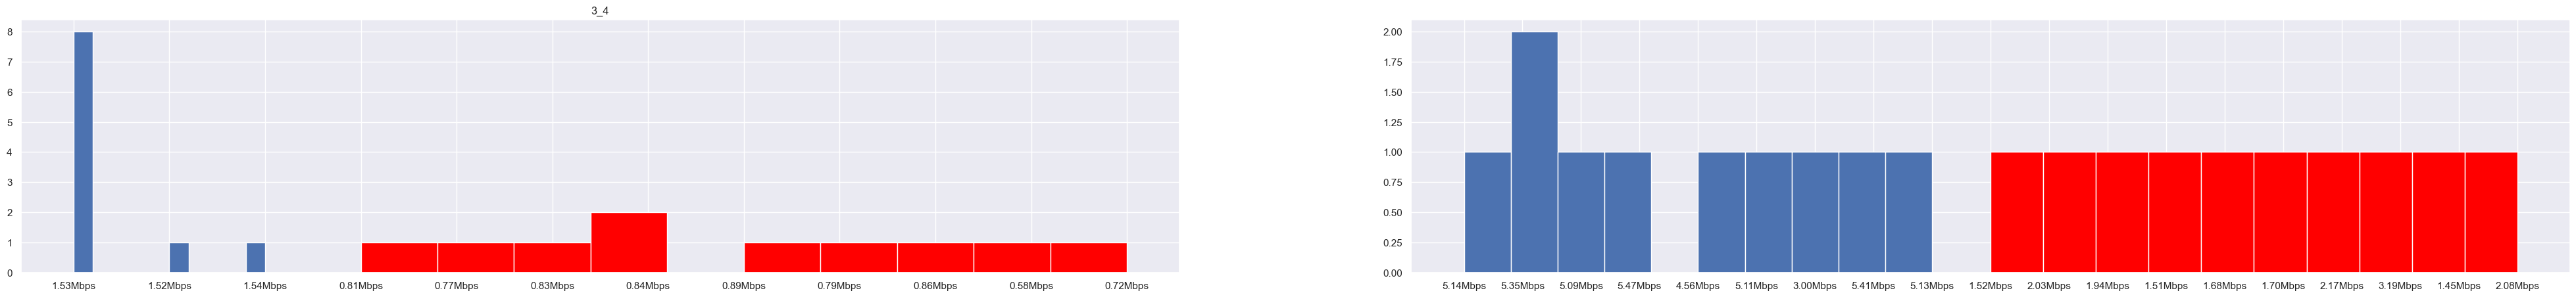

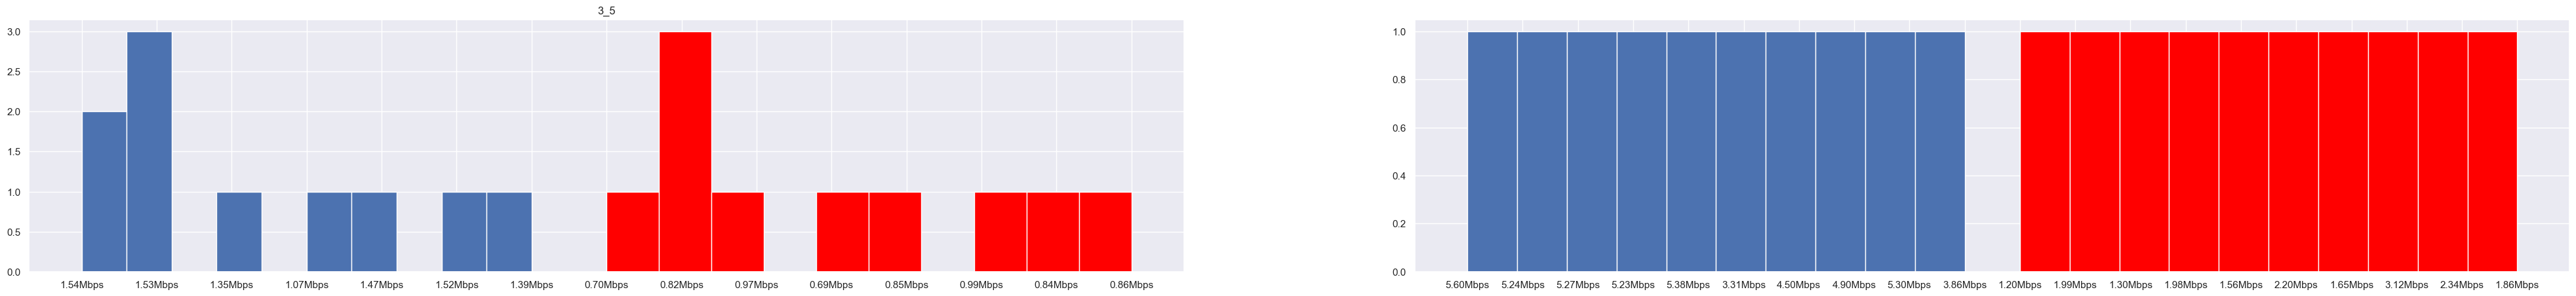

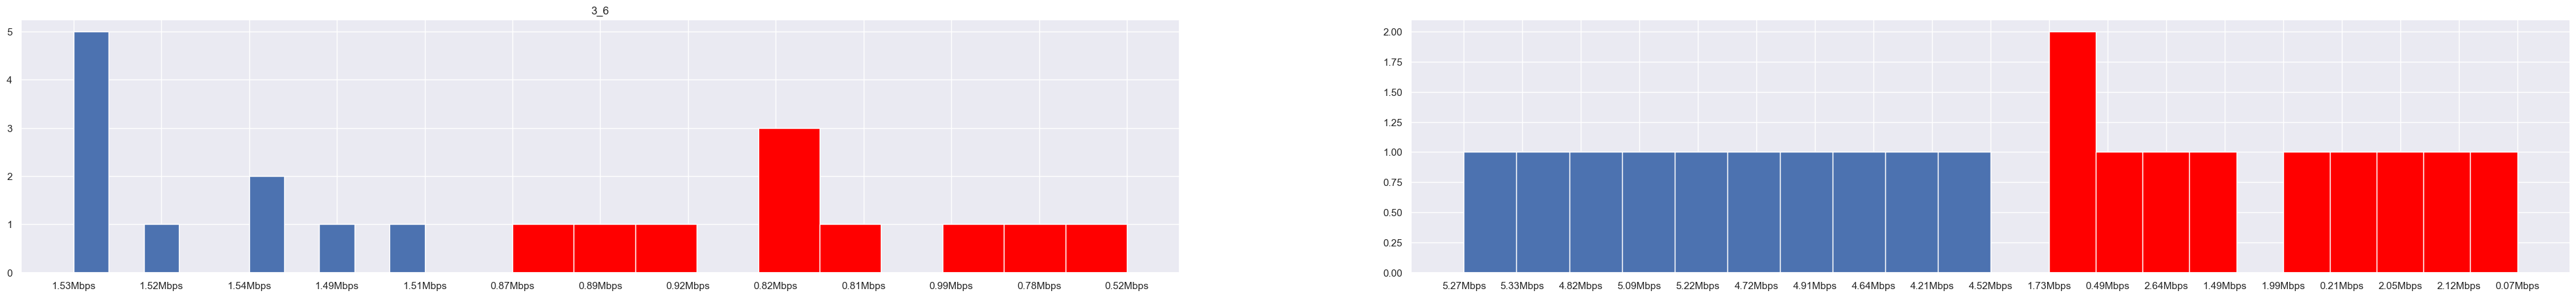

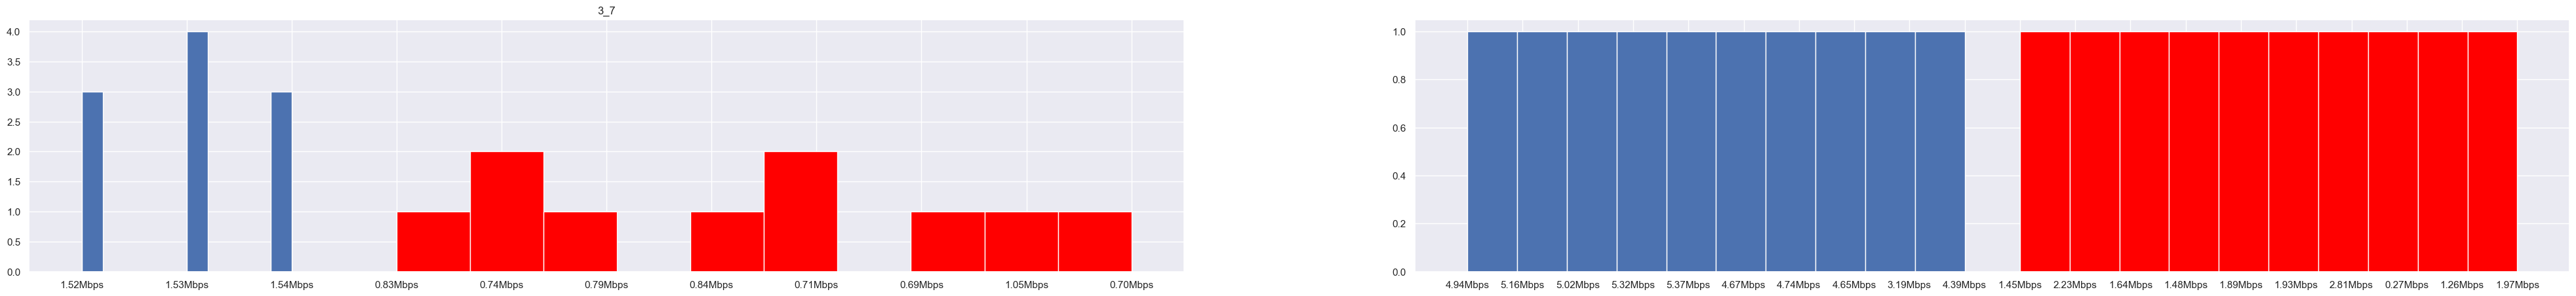

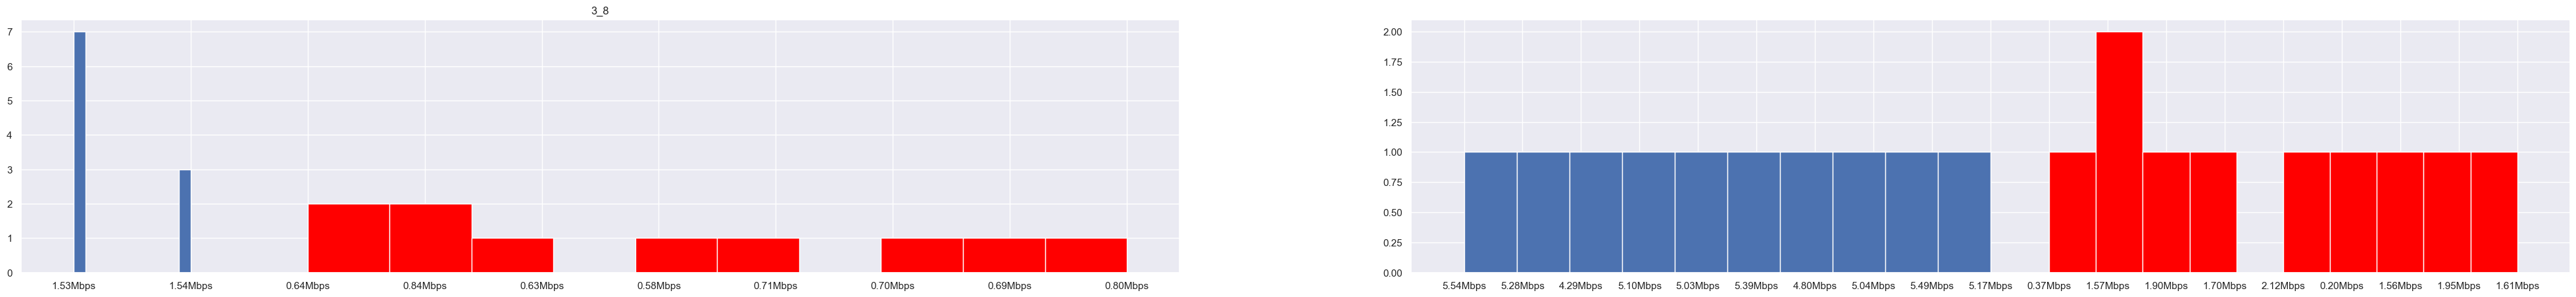

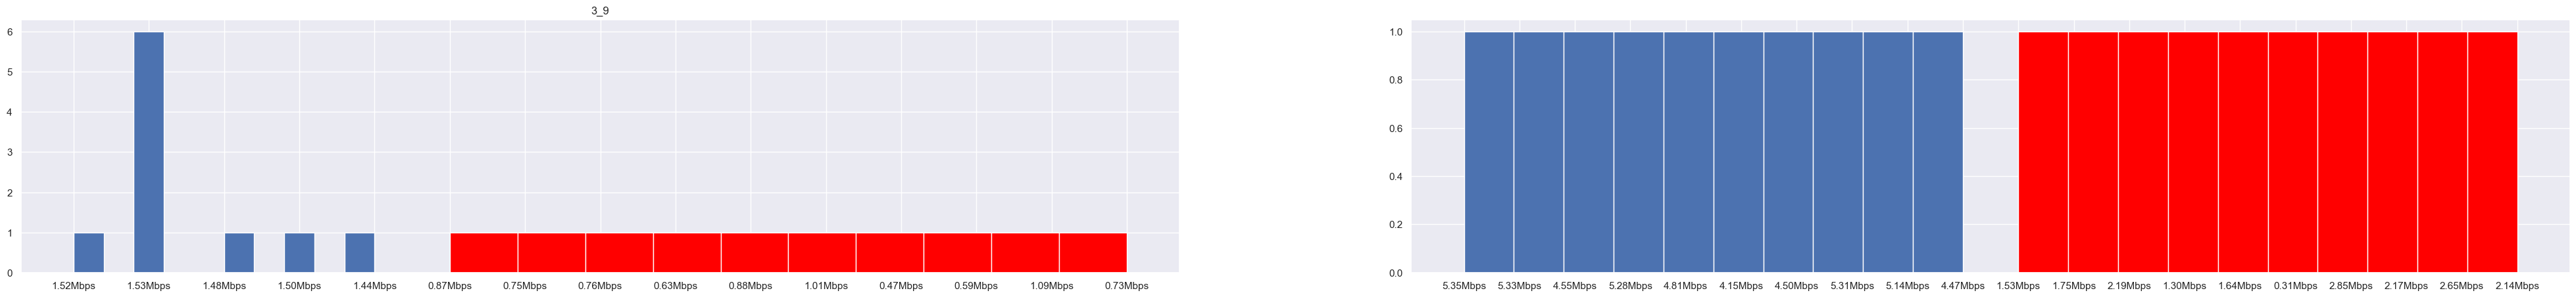

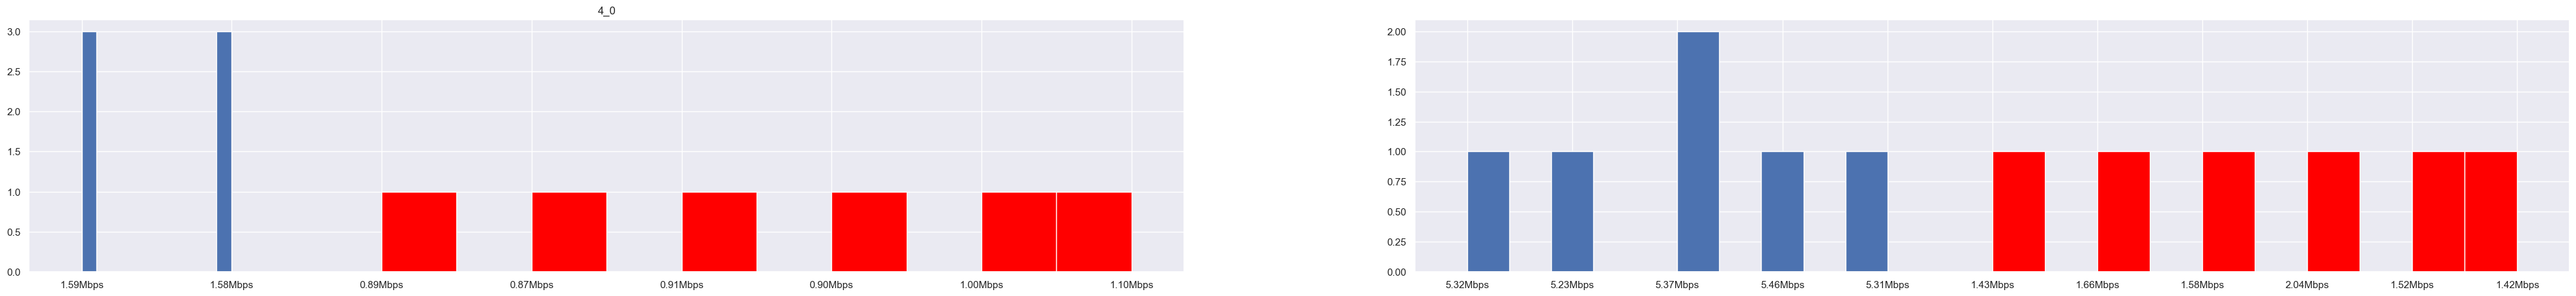

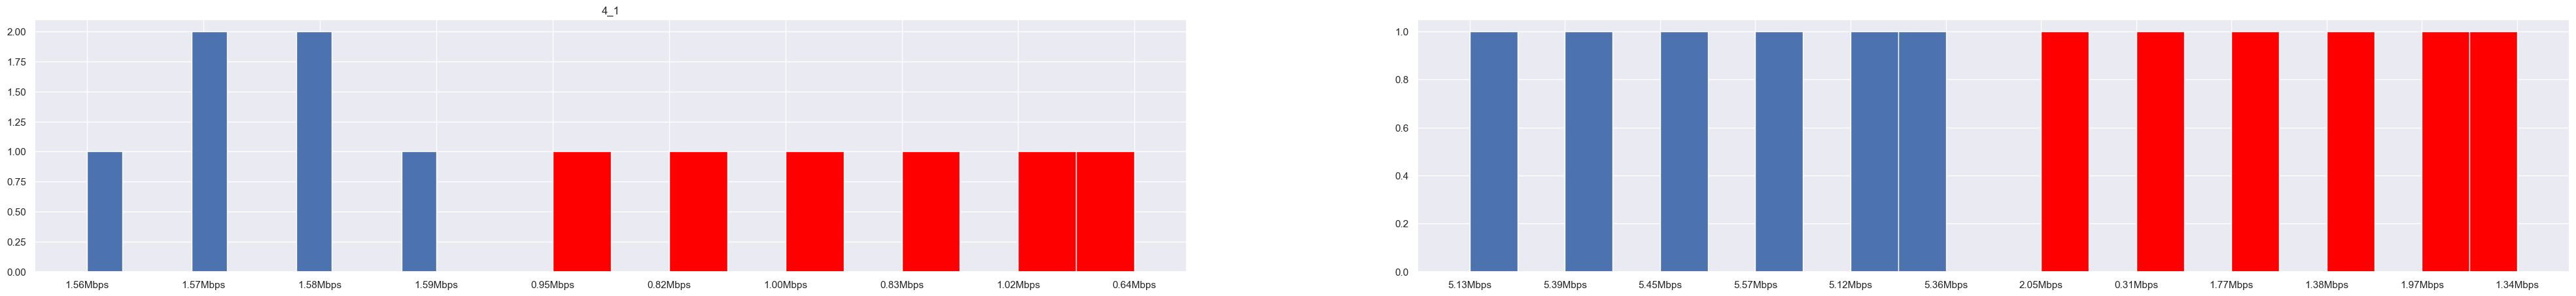

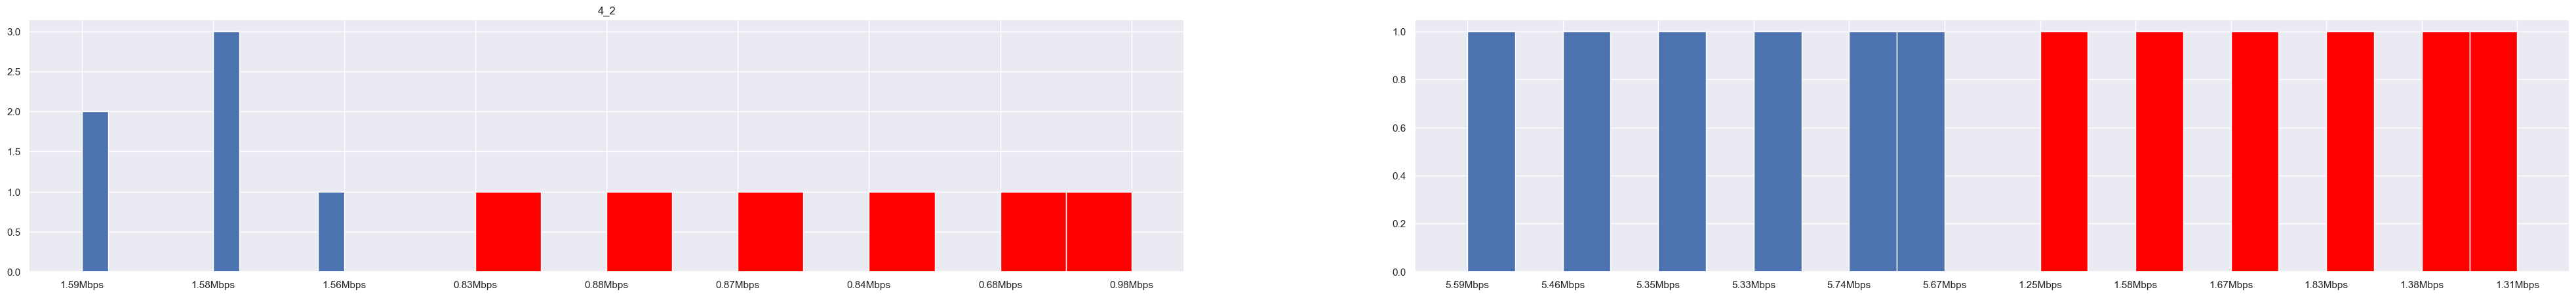

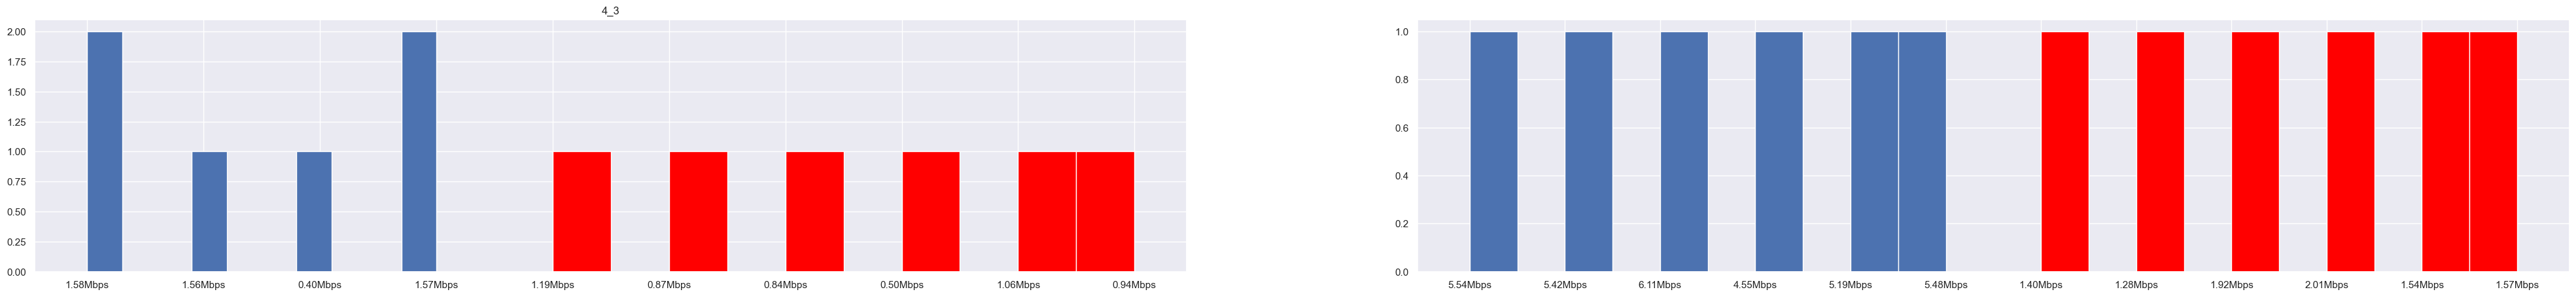

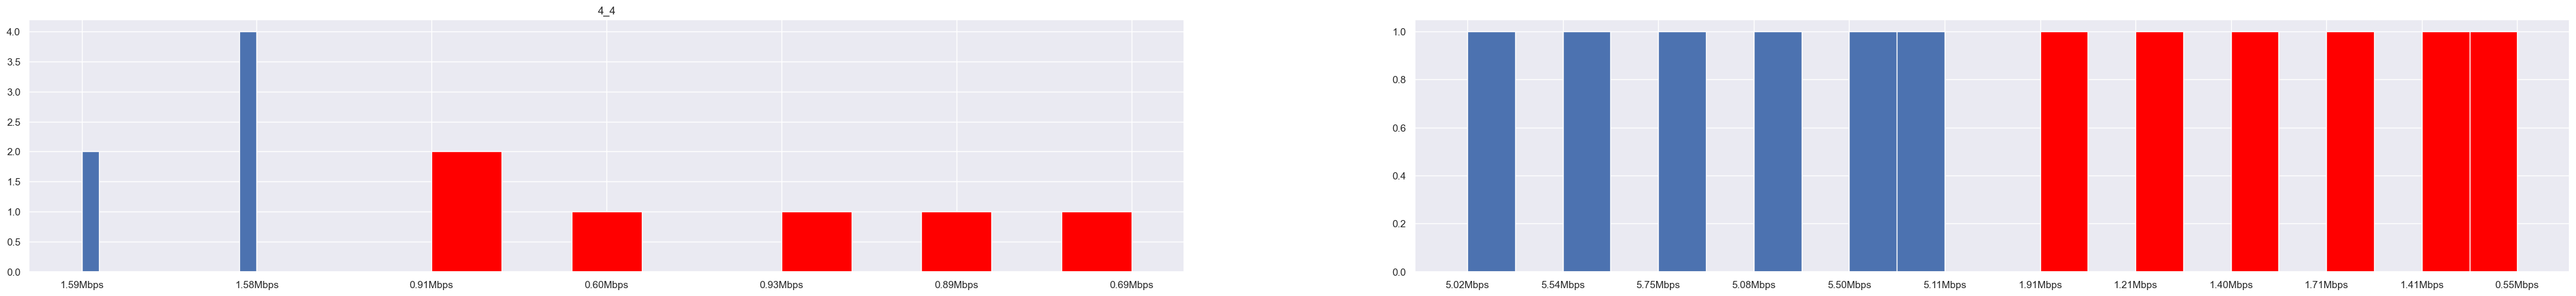

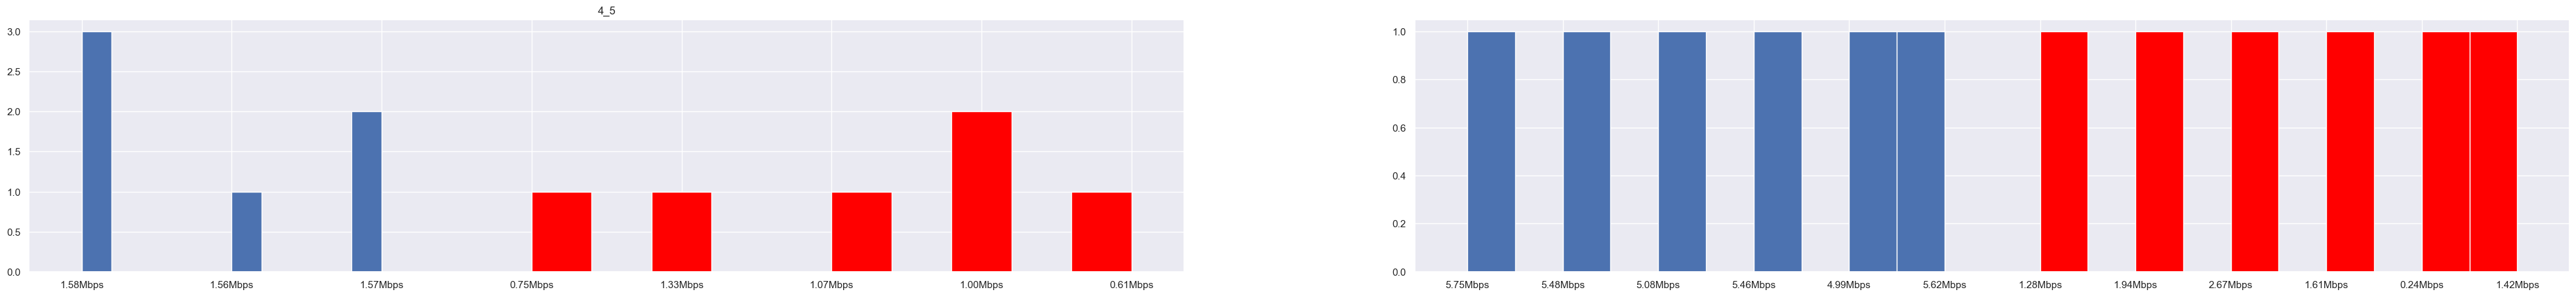

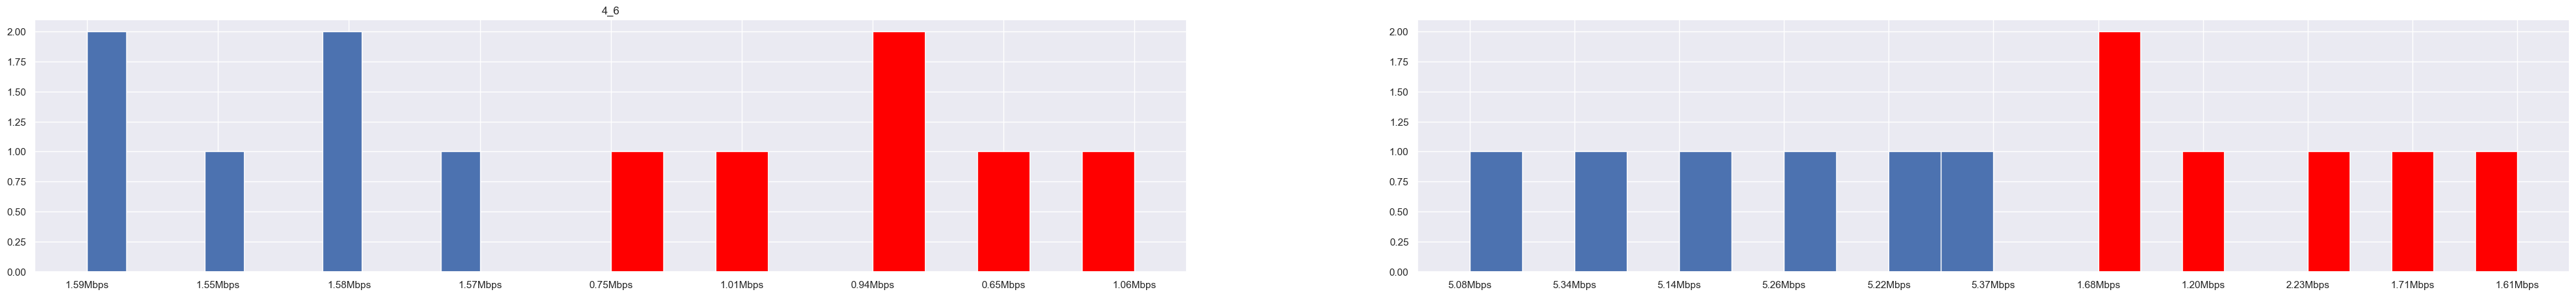

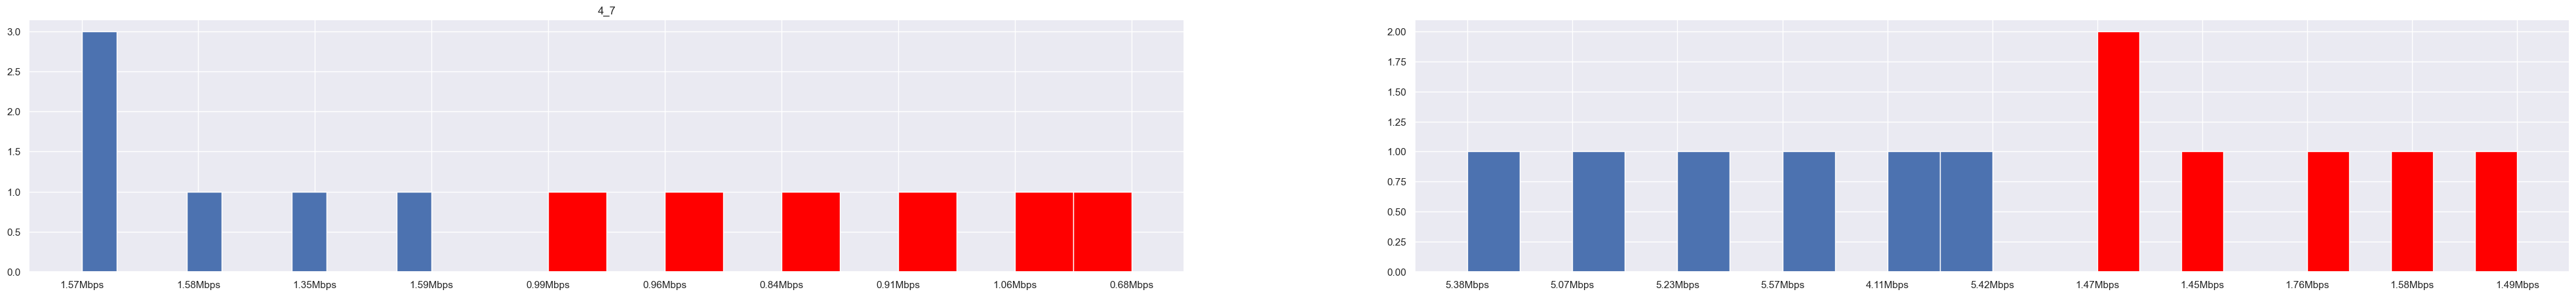

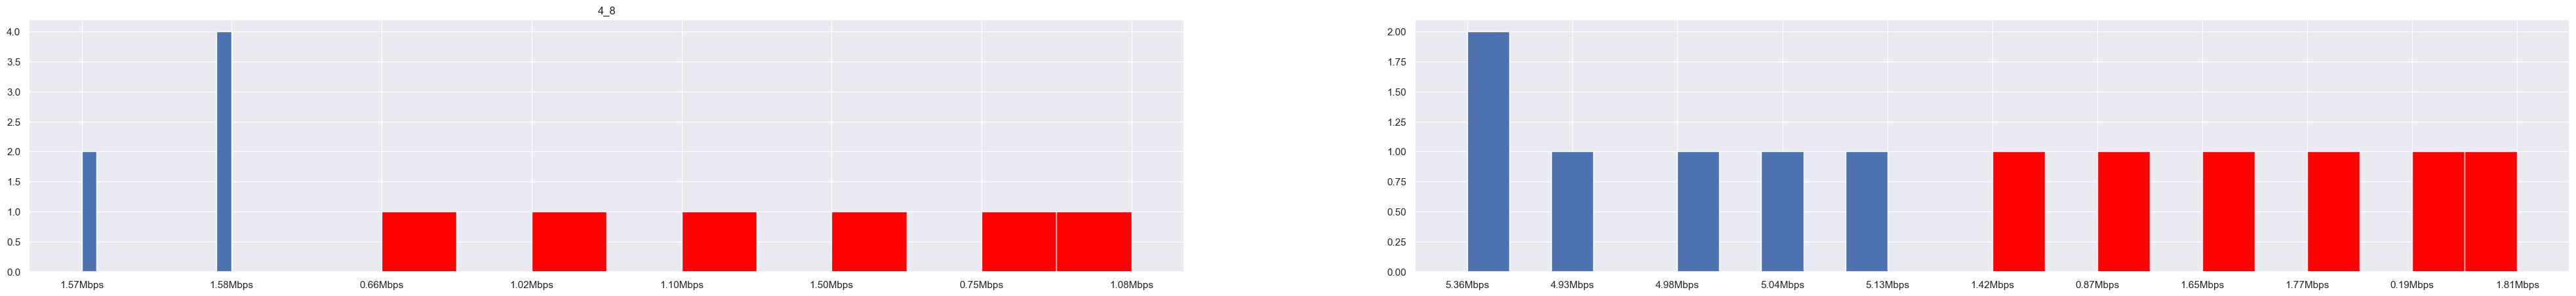

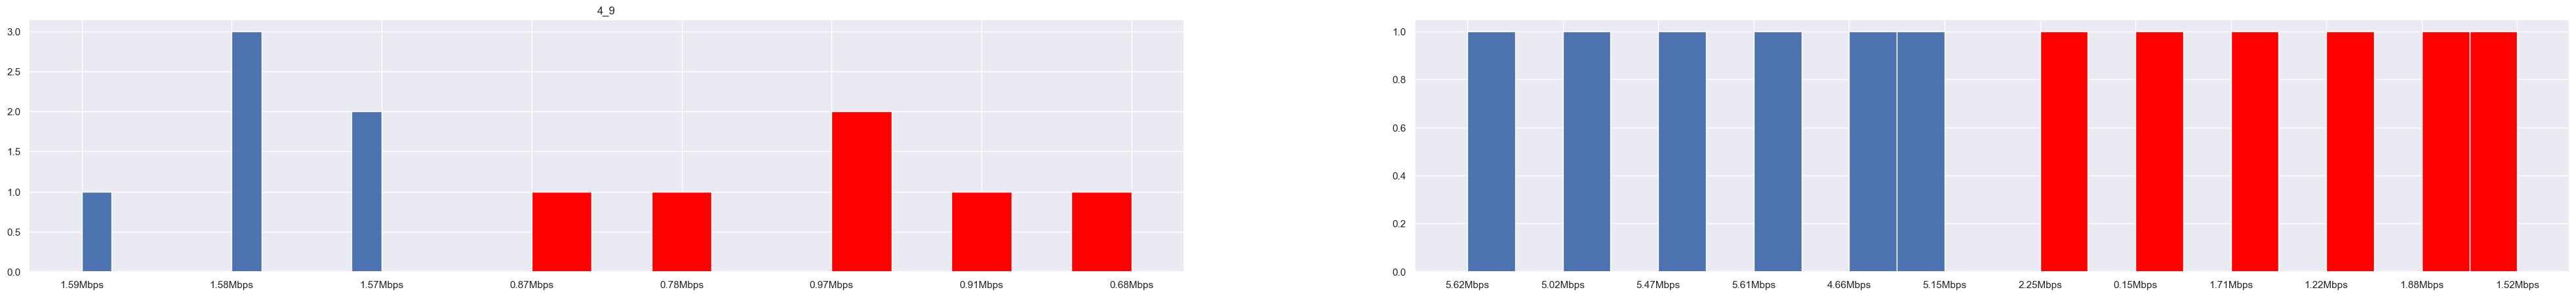

In [14]:
for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, (ax, bx) = plt.subplots(1,2, figsize=(50,5))
    ax.hist(d['avg_bandwidth_cs_64'])
    ax.hist(d['avg_bandwidth_cs_MTU'], color='red')
    bx.hist(d['avg_bandwidth_sc_64'])
    bx.hist(d['avg_bandwidth_sc_MTU'], color='red')
    ax.set_title(id)

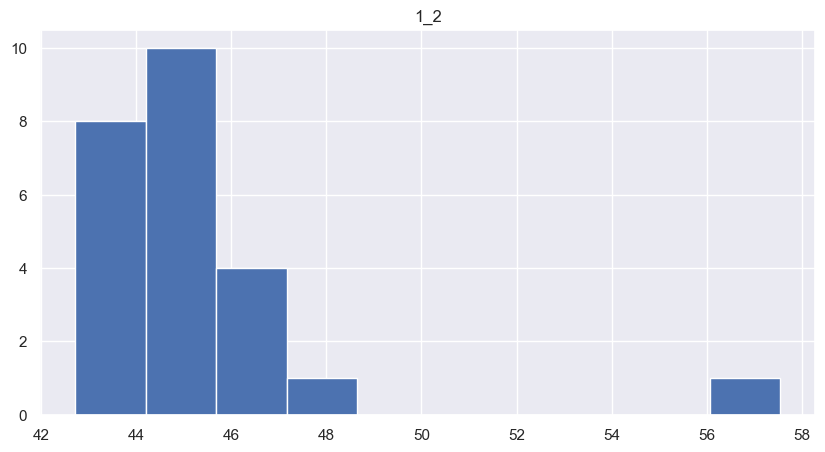

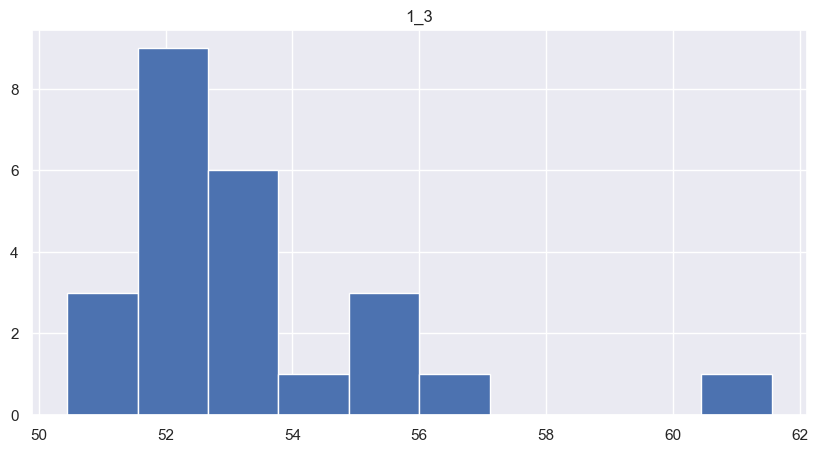

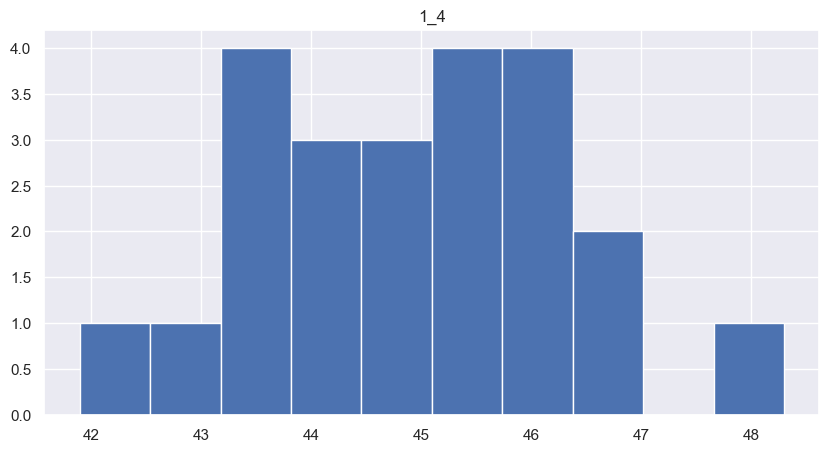

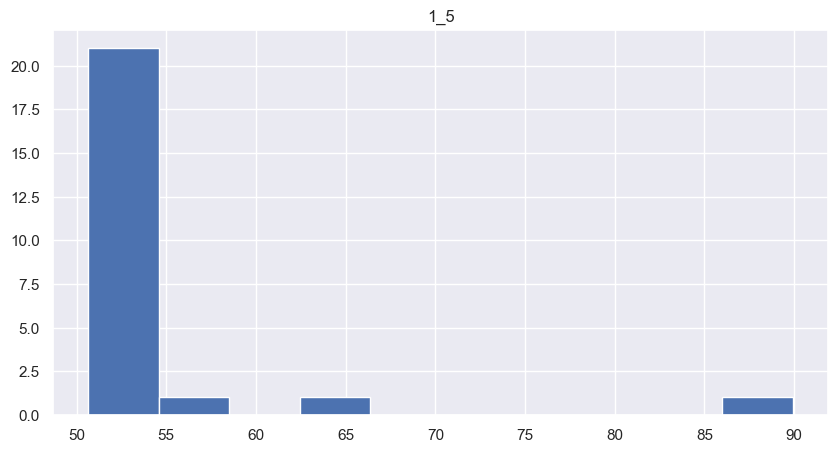

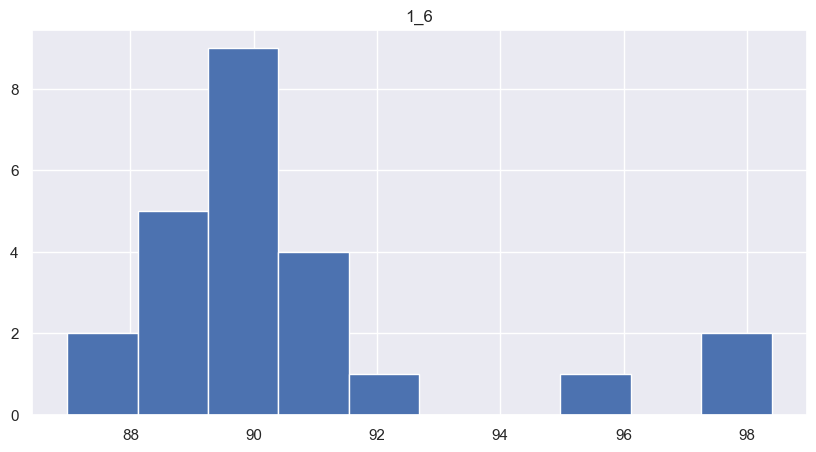

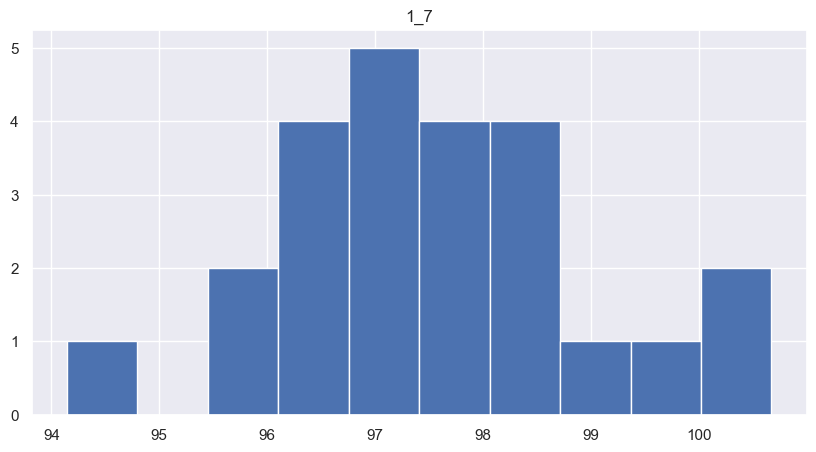

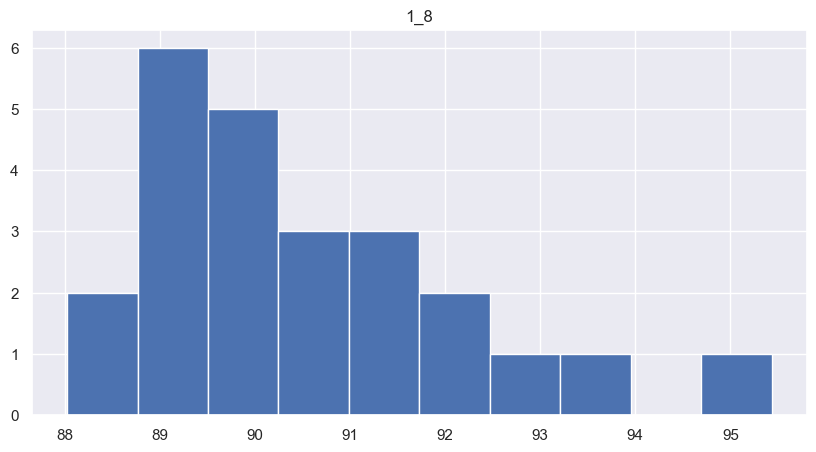

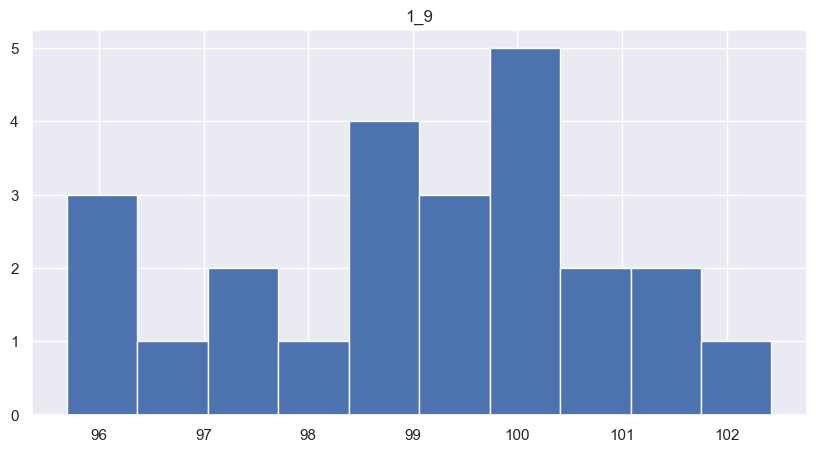

In [107]:
for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, ax = plt.subplots(1,1, figsize=(10,5))
    ax.hist(d['avg_latency'])
    ax.set_title(id)
    # sns.violinplot(d, hue_order=[True, False], split=True, ax=ax, orient='h')
